##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 組み込みメソッドを使用したトレーニングと評価

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/keras/train_and_evaluate"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a>   </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a>   </td>
</table>

## セットアップ

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-12-14 21:42:27.685244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:42:27.685342: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:42:27.685351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## はじめに

このガイドでは、トレーニングと検証に組み込みAPI（`model.fit()`、`model.evaluate()`、`model.predict()` など）を使用する場合のトレーニング、評価、予測（推論）モデルについて説明します。

独自のトレーニングステップ関数を指定しながら `fit()` を利用する場合は、<a data-md-type="raw_html" href="https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/">「`fit()` の処理をカスタマイズする」ガイド</a>をご覧ください。

独自のトレーニングと評価ループを新規に作成する場合は、[「トレーニングループの新規作成」](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/)をご覧ください。

一般的にモデルのトレーニングと評価は、組み込みループを使用するか独自のループを作成するかに関係なく、すべての Keras モデル（Sequential モデル、Functional API を使用して構築されたモデル、モデルのサブクラス化により新規作成されたモデル）で同じように機能します。

このガイドは、分散型トレーニングについては説明されていません。この説明は[マルチ GPU と分散型トレーニングに関するガイド](https://keras.io/guides/distributed_training/)をご覧ください。

## API の概要：最初のエンドツーエンドの例

モデルの組み込みトレーニングループにデータを渡すときは、**NumPy 配列**（データが小さく、メモリに収まる場合）または **`tf.data Dataset` オブジェクト**を使用する必要があります。 以下の例では、オプティマイザ、損失、およびメトリクスの使用方法を示すために、MNIST データセットを NumPy 配列として使用します。

次のモデルを見てみましょう（ここでは、Functional API を使用して構築していますが、Sequential モデルまたはサブクラス化モデルも使用可能です）。

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

一般的なエンドツーエンドのワークフローは以下のとおりです。

- トレーニング
- 元のトレーニングデータから生成されたホールドアウトセットの検証
- テストデータの評価

この例では MNIST データを使用します。

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

トレーニングの構成（オプティマイザ、損失、メトリクス）を指定します。

In [5]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`fit()` を呼び出します。これは、データを `batch_size` サイズの「バッチ」にスライスし、指定された数の `epochs` 間にデータセット全体を繰り返しイテレートすることでモデルをトレーニングします。

In [6]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2


  1/782 [..............................] - ETA: 17:31 - loss: 2.3241 - sparse_categorical_accuracy: 0.1406

 22/782 [..............................] - ETA: 1s - loss: 1.7083 - sparse_categorical_accuracy: 0.5234   

 45/782 [>.............................] - ETA: 1s - loss: 1.3042 - sparse_categorical_accuracy: 0.6594

 68/782 [=>............................] - ETA: 1s - loss: 1.0756 - sparse_categorical_accuracy: 0.7213

 91/782 [==>...........................] - ETA: 1s - loss: 0.9399 - sparse_categorical_accuracy: 0.7514

113/782 [===>..........................] - ETA: 1s - loss: 0.8407 - sparse_categorical_accuracy: 0.7753

135/782 [====>.........................] - ETA: 1s - loss: 0.7746 - sparse_categorical_accuracy: 0.7922

157/782 [=====>........................] - ETA: 1s - loss: 0.7186 - sparse_categorical_accuracy: 0.8058

180/782 [=====>........................] - ETA: 1s - loss: 0.6747 - sparse_categorical_accuracy: 0.8174

203/782 [======>.......................] - ETA: 1s - loss: 0.6352 - sparse_categorical_accuracy: 0.8264

225/782 [=======>......................] - ETA: 1s - loss: 0.6075 - sparse_categorical_accuracy: 0.8340

247/782 [========>.....................] - ETA: 1s - loss: 0.5851 - sparse_categorical_accuracy: 0.8388

270/782 [=========>....................] - ETA: 1s - loss: 0.5590 - sparse_categorical_accuracy: 0.8456

292/782 [==========>...................] - ETA: 1s - loss: 0.5412 - sparse_categorical_accuracy: 0.8502

314/782 [===========>..................] - ETA: 1s - loss: 0.5244 - sparse_categorical_accuracy: 0.8550

336/782 [===========>..................] - ETA: 1s - loss: 0.5097 - sparse_categorical_accuracy: 0.8591

360/782 [============>.................] - ETA: 0s - loss: 0.4942 - sparse_categorical_accuracy: 0.8633

384/782 [=============>................] - ETA: 0s - loss: 0.4817 - sparse_categorical_accuracy: 0.8659

407/782 [==============>...............] - ETA: 0s - loss: 0.4720 - sparse_categorical_accuracy: 0.8689

430/782 [===============>..............] - ETA: 0s - loss: 0.4641 - sparse_categorical_accuracy: 0.8709

453/782 [================>.............] - ETA: 0s - loss: 0.4543 - sparse_categorical_accuracy: 0.8735

476/782 [=================>............] - ETA: 0s - loss: 0.4471 - sparse_categorical_accuracy: 0.8754

500/782 [==================>...........] - ETA: 0s - loss: 0.4382 - sparse_categorical_accuracy: 0.8776

524/782 [===================>..........] - ETA: 0s - loss: 0.4286 - sparse_categorical_accuracy: 0.8800

549/782 [====================>.........] - ETA: 0s - loss: 0.4210 - sparse_categorical_accuracy: 0.8821

573/782 [====================>.........] - ETA: 0s - loss: 0.4135 - sparse_categorical_accuracy: 0.8843

598/782 [=====================>........] - ETA: 0s - loss: 0.4059 - sparse_categorical_accuracy: 0.8862

622/782 [======================>.......] - ETA: 0s - loss: 0.3985 - sparse_categorical_accuracy: 0.8881

646/782 [=======================>......] - ETA: 0s - loss: 0.3935 - sparse_categorical_accuracy: 0.8892

670/782 [========================>.....] - ETA: 0s - loss: 0.3877 - sparse_categorical_accuracy: 0.8907

694/782 [=========================>....] - ETA: 0s - loss: 0.3820 - sparse_categorical_accuracy: 0.8920

718/782 [==========================>...] - ETA: 0s - loss: 0.3771 - sparse_categorical_accuracy: 0.8935

742/782 [===========================>..] - ETA: 0s - loss: 0.3725 - sparse_categorical_accuracy: 0.8947

766/782 [============================>.] - ETA: 0s - loss: 0.3675 - sparse_categorical_accuracy: 0.8962

782/782 [==============================] - 4s 3ms/step - loss: 0.3639 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.1885 - val_sparse_categorical_accuracy: 0.9446


Epoch 2/2


  1/782 [..............................] - ETA: 2s - loss: 0.4426 - sparse_categorical_accuracy: 0.8906

 24/782 [..............................] - ETA: 1s - loss: 0.2086 - sparse_categorical_accuracy: 0.9368

 46/782 [>.............................] - ETA: 1s - loss: 0.1918 - sparse_categorical_accuracy: 0.9423

 68/782 [=>............................] - ETA: 1s - loss: 0.1938 - sparse_categorical_accuracy: 0.9430

 91/782 [==>...........................] - ETA: 1s - loss: 0.1963 - sparse_categorical_accuracy: 0.9414

115/782 [===>..........................] - ETA: 1s - loss: 0.2004 - sparse_categorical_accuracy: 0.9416

139/782 [====>.........................] - ETA: 1s - loss: 0.2052 - sparse_categorical_accuracy: 0.9404

163/782 [=====>........................] - ETA: 1s - loss: 0.2029 - sparse_categorical_accuracy: 0.9410

187/782 [======>.......................] - ETA: 1s - loss: 0.1962 - sparse_categorical_accuracy: 0.9431

211/782 [=======>......................] - ETA: 1s - loss: 0.1955 - sparse_categorical_accuracy: 0.9427

235/782 [========>.....................] - ETA: 1s - loss: 0.1938 - sparse_categorical_accuracy: 0.9434

259/782 [========>.....................] - ETA: 1s - loss: 0.1931 - sparse_categorical_accuracy: 0.9434

284/782 [=========>....................] - ETA: 1s - loss: 0.1926 - sparse_categorical_accuracy: 0.9436

309/782 [==========>...................] - ETA: 1s - loss: 0.1936 - sparse_categorical_accuracy: 0.9433

334/782 [===========>..................] - ETA: 0s - loss: 0.1915 - sparse_categorical_accuracy: 0.9441

358/782 [============>.................] - ETA: 0s - loss: 0.1894 - sparse_categorical_accuracy: 0.9450

382/782 [=============>................] - ETA: 0s - loss: 0.1891 - sparse_categorical_accuracy: 0.9450

406/782 [==============>...............] - ETA: 0s - loss: 0.1865 - sparse_categorical_accuracy: 0.9454

430/782 [===============>..............] - ETA: 0s - loss: 0.1851 - sparse_categorical_accuracy: 0.9458

454/782 [================>.............] - ETA: 0s - loss: 0.1831 - sparse_categorical_accuracy: 0.9461

478/782 [=================>............] - ETA: 0s - loss: 0.1833 - sparse_categorical_accuracy: 0.9460

502/782 [==================>...........] - ETA: 0s - loss: 0.1827 - sparse_categorical_accuracy: 0.9458

526/782 [===================>..........] - ETA: 0s - loss: 0.1816 - sparse_categorical_accuracy: 0.9461

550/782 [====================>.........] - ETA: 0s - loss: 0.1811 - sparse_categorical_accuracy: 0.9462

575/782 [=====================>........] - ETA: 0s - loss: 0.1802 - sparse_categorical_accuracy: 0.9465

599/782 [=====================>........] - ETA: 0s - loss: 0.1788 - sparse_categorical_accuracy: 0.9469

623/782 [======================>.......] - ETA: 0s - loss: 0.1769 - sparse_categorical_accuracy: 0.9473

647/782 [=======================>......] - ETA: 0s - loss: 0.1755 - sparse_categorical_accuracy: 0.9478

671/782 [========================>.....] - ETA: 0s - loss: 0.1733 - sparse_categorical_accuracy: 0.9483

695/782 [=========================>....] - ETA: 0s - loss: 0.1723 - sparse_categorical_accuracy: 0.9486

719/782 [==========================>...] - ETA: 0s - loss: 0.1722 - sparse_categorical_accuracy: 0.9487

743/782 [===========================>..] - ETA: 0s - loss: 0.1721 - sparse_categorical_accuracy: 0.9486

767/782 [============================>.] - ETA: 0s - loss: 0.1714 - sparse_categorical_accuracy: 0.9489

782/782 [==============================] - 2s 2ms/step - loss: 0.1708 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.1303 - val_sparse_categorical_accuracy: 0.9621


返された `history` オブジェクトは、トレーニング間の損失値とメトリクス値の記録を保持します。

In [7]:
history.history

{'loss': [0.36385416984558105, 0.17080071568489075],
 'sparse_categorical_accuracy': [0.8973000049591064, 0.94896000623703],
 'val_loss': [0.18849268555641174, 0.13027681410312653],
 'val_sparse_categorical_accuracy': [0.944599986076355, 0.9621000289916992]}

`evaluate()` を介してテストデータでモデルを評価します。

In [8]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
 1/79 [..............................] - ETA: 1s - loss: 0.0377 - sparse_categorical_accuracy: 1.0000

28/79 [=========>....................] - ETA: 0s - loss: 0.1690 - sparse_categorical_accuracy: 0.9506

55/79 [===================>..........] - ETA: 0s - loss: 0.1542 - sparse_categorical_accuracy: 0.9541

79/79 [==============================] - 0s 2ms/step - loss: 0.1316 - sparse_categorical_accuracy: 0.9607


test loss, test acc: [0.13158978521823883, 0.9606999754905701]
Generate predictions for 3 samples


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 71ms/step


predictions shape: (3, 10)


では、このワークフローの各部分を詳しく見ていきましょう。

## `compile()` メソッド: 損失、メトリクス、およびオプティマイザを指定する

`fit()` を使用してモデルをトレーニングするには、損失関数、オプティマイザ、および必要に応じて監視するメトリクスを指定する必要があります。

これらを `compile()` メソッドの引数としてモデルに渡します。

In [9]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics` 引数はリストである必要があります。モデルは任意の数のメトリクスを持つことができます。

モデルに複数の出力がある場合、出力ごとに異なる損失とメトリクスを指定でき、モデルの総損失に対する各出力の貢献を修正できます。詳細については、「 **データを多入力多出力モデルに渡す**」セクションをご覧ください。

デフォルト設定に満足している場合、多くの場合、オプティマイザ、損失、およびメトリクスは、ショートカットとして文字列識別子を介して指定できます。

In [10]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

後で再利用できるよう、モデルの定義とコンパイルの手順を関数に入れましょう。このガイドでは、さまざまな例でこの関数を何度か呼び出しています。

In [11]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### 提供されている多数の組み込みオプティマイザ、損失、およびメトリクス

一般的に、Keras API には必要とされているものが含まれているため、一般的に、独自の損失、メトリクス、またはオプティマイザを新規作成する必要はありません。

オプティマイザ:

- `SGD()`（モメンタムの有無に関係なく）
- `RMSprop()`
- `Adam()`
- など

損失：

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- など

メトリクス:

- `AUC()`
- `Precision()`
- `Recall()`
- など

### カスタム損失

カスタム損失を作成する必要がある場合、Keras には作成する方法が 2 つあります。

最初の方法は、入力 `y_true` と `y_pred` を受け入れる関数を作成する方法です。次の例は、実データと予測の間の平均二乗誤差を計算する損失関数を示しています。

In [12]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 14:09 - loss: 0.0901

 24/782 [..............................] - ETA: 1s - loss: 0.0783   

 50/782 [>.............................] - ETA: 1s - loss: 0.0607

 75/782 [=>............................] - ETA: 1s - loss: 0.0499

100/782 [==>...........................] - ETA: 1s - loss: 0.0432

125/782 [===>..........................] - ETA: 1s - loss: 0.0385

151/782 [====>.........................] - ETA: 1s - loss: 0.0351

176/782 [=====>........................] - ETA: 1s - loss: 0.0323

202/782 [======>.......................] - ETA: 1s - loss: 0.0302

228/782 [=======>......................] - ETA: 1s - loss: 0.0284

254/782 [========>.....................] - ETA: 1s - loss: 0.0269

279/782 [=========>....................] - ETA: 1s - loss: 0.0258

305/782 [==========>...................] - ETA: 0s - loss: 0.0248

331/782 [===========>..................] - ETA: 0s - loss: 0.0240

357/782 [============>.................] - ETA: 0s - loss: 0.0233

382/782 [=============>................] - ETA: 0s - loss: 0.0226

408/782 [==============>...............] - ETA: 0s - loss: 0.0219

434/782 [===============>..............] - ETA: 0s - loss: 0.0213

459/782 [================>.............] - ETA: 0s - loss: 0.0208

484/782 [=================>............] - ETA: 0s - loss: 0.0203

509/782 [==================>...........] - ETA: 0s - loss: 0.0198

534/782 [===================>..........] - ETA: 0s - loss: 0.0194

559/782 [====================>.........] - ETA: 0s - loss: 0.0190

584/782 [=====================>........] - ETA: 0s - loss: 0.0187

609/782 [======================>.......] - ETA: 0s - loss: 0.0184

634/782 [=======================>......] - ETA: 0s - loss: 0.0180

659/782 [========================>.....] - ETA: 0s - loss: 0.0177

684/782 [=========================>....] - ETA: 0s - loss: 0.0174

709/782 [==========================>...] - ETA: 0s - loss: 0.0172

735/782 [===========================>..] - ETA: 0s - loss: 0.0169

761/782 [============================>.] - ETA: 0s - loss: 0.0167

782/782 [==============================] - 3s 2ms/step - loss: 0.0165


`y_true`および`y_pred`以外のパラメータを取る損失関数が必要な場合は、`tf.keras.losses.Loss` クラスをサブクラス化して、次の 2 つのメソッドを実装できます。

- `__init__(self)`: 損失関数の呼び出し中に渡すパラメータを受け入れる
- `call(self, y_true, y_pred)`: ターゲット（y_true）とモデル予測（y_pred）を使用してモデルの損失を計算する

平均二乗誤差を使用する際に、0.5 より離れた予測値にペナルティを与えるとします（カテゴリターゲットはワンホットエンコードされ、0 と 1 の間の値を取ると想定します）。これにより、モデルの信頼性が調整され、過剰適合を防ぐのに役立ちます（ただし、実際に試してみるまで、その効果はわかりません！）。

以下のように記述します。

In [13]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 12:14 - loss: 0.1084

 22/782 [..............................] - ETA: 1s - loss: 0.0978   

 45/782 [>.............................] - ETA: 1s - loss: 0.0819

 67/782 [=>............................] - ETA: 1s - loss: 0.0718

 89/782 [==>...........................] - ETA: 1s - loss: 0.0651

111/782 [===>..........................] - ETA: 1s - loss: 0.0608

133/782 [====>.........................] - ETA: 1s - loss: 0.0572

155/782 [====>.........................] - ETA: 1s - loss: 0.0548

178/782 [=====>........................] - ETA: 1s - loss: 0.0527

200/782 [======>.......................] - ETA: 1s - loss: 0.0509

222/782 [=======>......................] - ETA: 1s - loss: 0.0496

245/782 [========>.....................] - ETA: 1s - loss: 0.0485

268/782 [=========>....................] - ETA: 1s - loss: 0.0475

291/782 [==========>...................] - ETA: 1s - loss: 0.0465

314/782 [===========>..................] - ETA: 1s - loss: 0.0458

337/782 [===========>..................] - ETA: 1s - loss: 0.0451

360/782 [============>.................] - ETA: 0s - loss: 0.0445

382/782 [=============>................] - ETA: 0s - loss: 0.0440

405/782 [==============>...............] - ETA: 0s - loss: 0.0434

428/782 [===============>..............] - ETA: 0s - loss: 0.0430

451/782 [================>.............] - ETA: 0s - loss: 0.0426

473/782 [=================>............] - ETA: 0s - loss: 0.0423

495/782 [=================>............] - ETA: 0s - loss: 0.0420

517/782 [==================>...........] - ETA: 0s - loss: 0.0416

539/782 [===================>..........] - ETA: 0s - loss: 0.0413

562/782 [====================>.........] - ETA: 0s - loss: 0.0410

585/782 [=====================>........] - ETA: 0s - loss: 0.0407

607/782 [======================>.......] - ETA: 0s - loss: 0.0404

629/782 [=======================>......] - ETA: 0s - loss: 0.0402

651/782 [=======================>......] - ETA: 0s - loss: 0.0399

674/782 [========================>.....] - ETA: 0s - loss: 0.0397

698/782 [=========================>....] - ETA: 0s - loss: 0.0394

721/782 [==========================>...] - ETA: 0s - loss: 0.0392

744/782 [===========================>..] - ETA: 0s - loss: 0.0390

767/782 [============================>.] - ETA: 0s - loss: 0.0388

782/782 [==============================] - 3s 2ms/step - loss: 0.0387


### カスタムメトリック

API に含まれていないメトリックが必要な場合は、`tf.keras.metrics.Metric`クラスをサブクラス化することにより、カスタムメトリックを簡単に作成できます。

- `__init__(self)` - メトリックの状態変数を作成します。
- `update_state(self, y_true, y_pred, sample_weight=None)` - ターゲット (y_true) とモデル予測 (y_pred) を使用し状態変数を更新します。
- `result(self)` - 状態変数を使用して最終結果を計算します。
- `reset_state(self)` - メトリックの状態を再初期化します。

多くの場合、結果の計算に非常に負荷がかかり、定期的にしか実行されないため、状態の更新（`update_state()`）と結果の計算（`result()`）は別々に保持されます。

以下は、`CategoricalTruePositives`メトリックを実装する方法を示す簡単な例です。これは、特定のクラスに属するものとして正しく分類されたサンプル数を数えます。

In [14]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3


  1/782 [..............................] - ETA: 9:43 - loss: 2.3226 - categorical_true_positives: 11.0000

 23/782 [..............................] - ETA: 1s - loss: 1.5110 - categorical_true_positives: 903.0000 

 45/782 [>.............................] - ETA: 1s - loss: 1.1606 - categorical_true_positives: 2028.0000

 68/782 [=>............................] - ETA: 1s - loss: 0.9627 - categorical_true_positives: 3265.0000

 91/782 [==>...........................] - ETA: 1s - loss: 0.8428 - categorical_true_positives: 4545.0000

114/782 [===>..........................] - ETA: 1s - loss: 0.7553 - categorical_true_positives: 5841.0000

137/782 [====>.........................] - ETA: 1s - loss: 0.6929 - categorical_true_positives: 7145.0000

160/782 [=====>........................] - ETA: 1s - loss: 0.6457 - categorical_true_positives: 8461.0000

183/782 [======>.......................] - ETA: 1s - loss: 0.6074 - categorical_true_positives: 9795.0000

207/782 [======>.......................] - ETA: 1s - loss: 0.5778 - categorical_true_positives: 11161.0000

230/782 [=======>......................] - ETA: 1s - loss: 0.5538 - categorical_true_positives: 12487.0000

253/782 [========>.....................] - ETA: 1s - loss: 0.5323 - categorical_true_positives: 13820.0000

276/782 [=========>....................] - ETA: 1s - loss: 0.5136 - categorical_true_positives: 15161.0000

299/782 [==========>...................] - ETA: 1s - loss: 0.4978 - categorical_true_positives: 16491.0000

322/782 [===========>..................] - ETA: 1s - loss: 0.4852 - categorical_true_positives: 17827.0000

346/782 [============>.................] - ETA: 0s - loss: 0.4722 - categorical_true_positives: 19226.0000

370/782 [=============>................] - ETA: 0s - loss: 0.4571 - categorical_true_positives: 20660.0000

394/782 [==============>...............] - ETA: 0s - loss: 0.4453 - categorical_true_positives: 22068.0000

418/782 [===============>..............] - ETA: 0s - loss: 0.4334 - categorical_true_positives: 23501.0000

442/782 [===============>..............] - ETA: 0s - loss: 0.4253 - categorical_true_positives: 24912.0000

465/782 [================>.............] - ETA: 0s - loss: 0.4174 - categorical_true_positives: 26276.0000

488/782 [=================>............] - ETA: 0s - loss: 0.4098 - categorical_true_positives: 27632.0000

511/782 [==================>...........] - ETA: 0s - loss: 0.4026 - categorical_true_positives: 29002.0000

534/782 [===================>..........] - ETA: 0s - loss: 0.3934 - categorical_true_positives: 30385.0000

557/782 [====================>.........] - ETA: 0s - loss: 0.3862 - categorical_true_positives: 31755.0000

580/782 [=====================>........] - ETA: 0s - loss: 0.3813 - categorical_true_positives: 33104.0000

603/782 [======================>.......] - ETA: 0s - loss: 0.3745 - categorical_true_positives: 34489.0000

627/782 [=======================>......] - ETA: 0s - loss: 0.3690 - categorical_true_positives: 35916.0000

651/782 [=======================>......] - ETA: 0s - loss: 0.3648 - categorical_true_positives: 37338.0000

675/782 [========================>.....] - ETA: 0s - loss: 0.3598 - categorical_true_positives: 38771.0000

698/782 [=========================>....] - ETA: 0s - loss: 0.3549 - categorical_true_positives: 40152.0000

722/782 [==========================>...] - ETA: 0s - loss: 0.3504 - categorical_true_positives: 41596.0000

746/782 [===========================>..] - ETA: 0s - loss: 0.3462 - categorical_true_positives: 43022.0000

770/782 [============================>.] - ETA: 0s - loss: 0.3434 - categorical_true_positives: 44455.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.3412 - categorical_true_positives: 45135.0000


Epoch 2/3


  1/782 [..............................] - ETA: 2s - loss: 0.1047 - categorical_true_positives: 63.0000

 25/782 [..............................] - ETA: 1s - loss: 0.2043 - categorical_true_positives: 1507.0000

 49/782 [>.............................] - ETA: 1s - loss: 0.2056 - categorical_true_positives: 2945.0000

 73/782 [=>............................] - ETA: 1s - loss: 0.1923 - categorical_true_positives: 4406.0000

 97/782 [==>...........................] - ETA: 1s - loss: 0.1903 - categorical_true_positives: 5862.0000

122/782 [===>..........................] - ETA: 1s - loss: 0.1922 - categorical_true_positives: 7372.0000

146/782 [====>.........................] - ETA: 1s - loss: 0.1911 - categorical_true_positives: 8818.0000

170/782 [=====>........................] - ETA: 1s - loss: 0.1875 - categorical_true_positives: 10277.0000

193/782 [======>.......................] - ETA: 1s - loss: 0.1883 - categorical_true_positives: 11677.0000

217/782 [=======>......................] - ETA: 1s - loss: 0.1842 - categorical_true_positives: 13145.0000

241/782 [========>.....................] - ETA: 1s - loss: 0.1824 - categorical_true_positives: 14602.0000

265/782 [=========>....................] - ETA: 1s - loss: 0.1830 - categorical_true_positives: 16050.0000

288/782 [==========>...................] - ETA: 1s - loss: 0.1807 - categorical_true_positives: 17460.0000

312/782 [==========>...................] - ETA: 1s - loss: 0.1791 - categorical_true_positives: 18926.0000

336/782 [===========>..................] - ETA: 0s - loss: 0.1780 - categorical_true_positives: 20391.0000

360/782 [============>.................] - ETA: 0s - loss: 0.1756 - categorical_true_positives: 21859.0000

384/782 [=============>................] - ETA: 0s - loss: 0.1750 - categorical_true_positives: 23317.0000

408/782 [==============>...............] - ETA: 0s - loss: 0.1734 - categorical_true_positives: 24787.0000

432/782 [===============>..............] - ETA: 0s - loss: 0.1726 - categorical_true_positives: 26242.0000

456/782 [================>.............] - ETA: 0s - loss: 0.1737 - categorical_true_positives: 27692.0000

479/782 [=================>............] - ETA: 0s - loss: 0.1744 - categorical_true_positives: 29084.0000

502/782 [==================>...........] - ETA: 0s - loss: 0.1730 - categorical_true_positives: 30489.0000

526/782 [===================>..........] - ETA: 0s - loss: 0.1731 - categorical_true_positives: 31944.0000

550/782 [====================>.........] - ETA: 0s - loss: 0.1734 - categorical_true_positives: 33397.0000

573/782 [====================>.........] - ETA: 0s - loss: 0.1732 - categorical_true_positives: 34798.0000

596/782 [=====================>........] - ETA: 0s - loss: 0.1731 - categorical_true_positives: 36187.0000

619/782 [======================>.......] - ETA: 0s - loss: 0.1724 - categorical_true_positives: 37593.0000

642/782 [=======================>......] - ETA: 0s - loss: 0.1723 - categorical_true_positives: 38986.0000

665/782 [========================>.....] - ETA: 0s - loss: 0.1717 - categorical_true_positives: 40390.0000

688/782 [=========================>....] - ETA: 0s - loss: 0.1707 - categorical_true_positives: 41800.0000

712/782 [==========================>...] - ETA: 0s - loss: 0.1702 - categorical_true_positives: 43264.0000

735/782 [===========================>..] - ETA: 0s - loss: 0.1698 - categorical_true_positives: 44660.0000

758/782 [============================>.] - ETA: 0s - loss: 0.1692 - categorical_true_positives: 46070.0000

781/782 [============================>.] - ETA: 0s - loss: 0.1684 - categorical_true_positives: 47484.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.1684 - categorical_true_positives: 47499.0000


Epoch 3/3


  1/782 [..............................] - ETA: 2s - loss: 0.1548 - categorical_true_positives: 62.0000

 26/782 [..............................] - ETA: 1s - loss: 0.1384 - categorical_true_positives: 1596.0000

 50/782 [>.............................] - ETA: 1s - loss: 0.1505 - categorical_true_positives: 3066.0000

 74/782 [=>............................] - ETA: 1s - loss: 0.1401 - categorical_true_positives: 4544.0000

 97/782 [==>...........................] - ETA: 1s - loss: 0.1385 - categorical_true_positives: 5947.0000

121/782 [===>..........................] - ETA: 1s - loss: 0.1382 - categorical_true_positives: 7422.0000

144/782 [====>.........................] - ETA: 1s - loss: 0.1427 - categorical_true_positives: 8824.0000

168/782 [=====>........................] - ETA: 1s - loss: 0.1384 - categorical_true_positives: 10301.0000

192/782 [======>.......................] - ETA: 1s - loss: 0.1377 - categorical_true_positives: 11768.0000

216/782 [=======>......................] - ETA: 1s - loss: 0.1359 - categorical_true_positives: 13243.0000

240/782 [========>.....................] - ETA: 1s - loss: 0.1349 - categorical_true_positives: 14716.0000

264/782 [=========>....................] - ETA: 1s - loss: 0.1325 - categorical_true_positives: 16199.0000

288/782 [==========>...................] - ETA: 1s - loss: 0.1317 - categorical_true_positives: 17676.0000

311/782 [==========>...................] - ETA: 1s - loss: 0.1323 - categorical_true_positives: 19090.0000

334/782 [===========>..................] - ETA: 0s - loss: 0.1315 - categorical_true_positives: 20508.0000

357/782 [============>.................] - ETA: 0s - loss: 0.1292 - categorical_true_positives: 21932.0000

381/782 [=============>................] - ETA: 0s - loss: 0.1299 - categorical_true_positives: 23407.0000

404/782 [==============>...............] - ETA: 0s - loss: 0.1289 - categorical_true_positives: 24832.0000

427/782 [===============>..............] - ETA: 0s - loss: 0.1284 - categorical_true_positives: 26249.0000

451/782 [================>.............] - ETA: 0s - loss: 0.1281 - categorical_true_positives: 27721.0000

474/782 [=================>............] - ETA: 0s - loss: 0.1264 - categorical_true_positives: 29151.0000

497/782 [==================>...........] - ETA: 0s - loss: 0.1262 - categorical_true_positives: 30566.0000

520/782 [==================>...........] - ETA: 0s - loss: 0.1254 - categorical_true_positives: 31987.0000

544/782 [===================>..........] - ETA: 0s - loss: 0.1252 - categorical_true_positives: 33466.0000

568/782 [====================>.........] - ETA: 0s - loss: 0.1250 - categorical_true_positives: 34947.0000

593/782 [=====================>........] - ETA: 0s - loss: 0.1262 - categorical_true_positives: 36480.0000

617/782 [======================>.......] - ETA: 0s - loss: 0.1261 - categorical_true_positives: 37965.0000

641/782 [=======================>......] - ETA: 0s - loss: 0.1252 - categorical_true_positives: 39450.0000

664/782 [========================>.....] - ETA: 0s - loss: 0.1258 - categorical_true_positives: 40864.0000

687/782 [=========================>....] - ETA: 0s - loss: 0.1262 - categorical_true_positives: 42276.0000

710/782 [==========================>...] - ETA: 0s - loss: 0.1264 - categorical_true_positives: 43687.0000

734/782 [===========================>..] - ETA: 0s - loss: 0.1259 - categorical_true_positives: 45166.0000

758/782 [============================>.] - ETA: 0s - loss: 0.1251 - categorical_true_positives: 46658.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.1245 - categorical_true_positives: 48095.0000


### 標準のシグネチャに適合しない損失と測定基準の処理

大多数の損失とメトリクスは、`y_true`および`y_pred`から計算できます。この場合、`y_pred`はモデルの出力です。例外として、正則化損失ではレイヤーのアクティブ化のみが必要で（この場合はターゲットはありません）、このアクティブ化はモデルの出力ではない場合があります。

このような場合は、カスタムレイヤーの呼び出しメソッド内から `self.add_loss(loss_value)` を呼び出すことができます。この方法で追加された損失は、トレーニング時に「メイン」の損失（`compile()` に渡されたもの）に追加されます。以下は、アクティビティの正規化を追加する簡単な例です（アクティビティの正規化はすべての Keras レイヤーに組み込まれています。このレイヤーは具体的な例を示すためのものです）。

In [15]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 8:43 - loss: 83.3503

 25/782 [..............................] - ETA: 1s - loss: 8.9729   

 49/782 [>.............................] - ETA: 1s - loss: 5.7699

 73/782 [=>............................] - ETA: 1s - loss: 4.6435

 98/782 [==>...........................] - ETA: 1s - loss: 4.0491

123/782 [===>..........................] - ETA: 1s - loss: 3.6963

148/782 [====>.........................] - ETA: 1s - loss: 3.4614

172/782 [=====>........................] - ETA: 1s - loss: 3.2999

196/782 [======>.......................] - ETA: 1s - loss: 3.1780

221/782 [=======>......................] - ETA: 1s - loss: 3.0790

246/782 [========>.....................] - ETA: 1s - loss: 3.0001

271/782 [=========>....................] - ETA: 1s - loss: 2.9356

296/782 [==========>...................] - ETA: 1s - loss: 2.8823

322/782 [===========>..................] - ETA: 0s - loss: 2.8355

347/782 [============>.................] - ETA: 0s - loss: 2.7972

373/782 [=============>................] - ETA: 0s - loss: 2.7626

398/782 [==============>...............] - ETA: 0s - loss: 2.7337

423/782 [===============>..............] - ETA: 0s - loss: 2.7081

448/782 [================>.............] - ETA: 0s - loss: 2.6855

473/782 [=================>............] - ETA: 0s - loss: 2.6652

498/782 [==================>...........] - ETA: 0s - loss: 2.6471

522/782 [===================>..........] - ETA: 0s - loss: 2.6311

546/782 [===================>..........] - ETA: 0s - loss: 2.6167

570/782 [====================>.........] - ETA: 0s - loss: 2.6034

594/782 [=====================>........] - ETA: 0s - loss: 2.5912

619/782 [======================>.......] - ETA: 0s - loss: 2.5797

643/782 [=======================>......] - ETA: 0s - loss: 2.5694

668/782 [========================>.....] - ETA: 0s - loss: 2.5594

693/782 [=========================>....] - ETA: 0s - loss: 2.5502

718/782 [==========================>...] - ETA: 0s - loss: 2.5415

743/782 [===========================>..] - ETA: 0s - loss: 2.5334

767/782 [============================>.] - ETA: 0s - loss: 2.5261

782/782 [==============================] - 2s 2ms/step - loss: 2.5220


`add_metric()` を使用して、メトリクス値のロギングに対して同じく実行できます。

In [16]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 8:59 - loss: 2.2954 - std_of_activation: 0.2711

 24/782 [..............................] - ETA: 1s - loss: 1.4947 - std_of_activation: 0.4643  

 48/782 [>.............................] - ETA: 1s - loss: 1.1490 - std_of_activation: 0.5745

 72/782 [=>............................] - ETA: 1s - loss: 0.9469 - std_of_activation: 0.6461

 96/782 [==>...........................] - ETA: 1s - loss: 0.8242 - std_of_activation: 0.6986

120/782 [===>..........................] - ETA: 1s - loss: 0.7362 - std_of_activation: 0.7388

144/782 [====>.........................] - ETA: 1s - loss: 0.6785 - std_of_activation: 0.7697

168/782 [=====>........................] - ETA: 1s - loss: 0.6305 - std_of_activation: 0.7937

192/782 [======>.......................] - ETA: 1s - loss: 0.5918 - std_of_activation: 0.8133

217/782 [=======>......................] - ETA: 1s - loss: 0.5610 - std_of_activation: 0.8317

242/782 [========>.....................] - ETA: 1s - loss: 0.5354 - std_of_activation: 0.8451

266/782 [=========>....................] - ETA: 1s - loss: 0.5141 - std_of_activation: 0.8564

290/782 [==========>...................] - ETA: 1s - loss: 0.4974 - std_of_activation: 0.8659

314/782 [===========>..................] - ETA: 0s - loss: 0.4819 - std_of_activation: 0.8738

338/782 [===========>..................] - ETA: 0s - loss: 0.4691 - std_of_activation: 0.8789

362/782 [============>.................] - ETA: 0s - loss: 0.4556 - std_of_activation: 0.8834

386/782 [=============>................] - ETA: 0s - loss: 0.4442 - std_of_activation: 0.8880

410/782 [==============>...............] - ETA: 0s - loss: 0.4318 - std_of_activation: 0.8934

434/782 [===============>..............] - ETA: 0s - loss: 0.4236 - std_of_activation: 0.8969

458/782 [================>.............] - ETA: 0s - loss: 0.4131 - std_of_activation: 0.9010

482/782 [=================>............] - ETA: 0s - loss: 0.4046 - std_of_activation: 0.9041

507/782 [==================>...........] - ETA: 0s - loss: 0.3950 - std_of_activation: 0.9071

532/782 [===================>..........] - ETA: 0s - loss: 0.3895 - std_of_activation: 0.9094

556/782 [====================>.........] - ETA: 0s - loss: 0.3829 - std_of_activation: 0.9110

580/782 [=====================>........] - ETA: 0s - loss: 0.3753 - std_of_activation: 0.9131

604/782 [======================>.......] - ETA: 0s - loss: 0.3706 - std_of_activation: 0.9148

628/782 [=======================>......] - ETA: 0s - loss: 0.3651 - std_of_activation: 0.9165

652/782 [========================>.....] - ETA: 0s - loss: 0.3601 - std_of_activation: 0.9181

676/782 [========================>.....] - ETA: 0s - loss: 0.3551 - std_of_activation: 0.9197

701/782 [=========================>....] - ETA: 0s - loss: 0.3498 - std_of_activation: 0.9208

726/782 [==========================>...] - ETA: 0s - loss: 0.3451 - std_of_activation: 0.9222

751/782 [===========================>..] - ETA: 0s - loss: 0.3402 - std_of_activation: 0.9234

775/782 [============================>.] - ETA: 0s - loss: 0.3364 - std_of_activation: 0.9246

782/782 [==============================] - 2s 2ms/step - loss: 0.3359 - std_of_activation: 0.9249


[Functional API](https://www.tensorflow.org/guide/keras/functional/) では、`model.add_loss(loss_tensor)` または `model.add_metric(metric_tensor, name, aggregation)` を呼び出せます。

簡単な例を下記に示します。

In [17]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 9:12 - loss: 76.1508 - std_of_activation: 0.2671

 25/782 [..............................] - ETA: 1s - loss: 8.2484 - std_of_activation: 0.0445   

 50/782 [>.............................] - ETA: 1s - loss: 5.3387 - std_of_activation: 0.0253

 75/782 [=>............................] - ETA: 1s - loss: 4.3352 - std_of_activation: 0.0177

100/782 [==>...........................] - ETA: 1s - loss: 3.8303 - std_of_activation: 0.0136

124/782 [===>..........................] - ETA: 1s - loss: 3.5356 - std_of_activation: 0.0111

148/782 [====>.........................] - ETA: 1s - loss: 3.3358 - std_of_activation: 0.0094

172/782 [=====>........................] - ETA: 1s - loss: 3.1921 - std_of_activation: 0.0082

197/782 [======>.......................] - ETA: 1s - loss: 3.0795 - std_of_activation: 0.0072

221/782 [=======>......................] - ETA: 1s - loss: 2.9951 - std_of_activation: 0.0064

245/782 [========>.....................] - ETA: 1s - loss: 2.9273 - std_of_activation: 0.0058

270/782 [=========>....................] - ETA: 1s - loss: 2.8698 - std_of_activation: 0.0053

294/782 [==========>...................] - ETA: 1s - loss: 2.8236 - std_of_activation: 0.0049

319/782 [===========>..................] - ETA: 0s - loss: 2.7828 - std_of_activation: 0.0046

343/782 [============>.................] - ETA: 0s - loss: 2.7494 - std_of_activation: 0.0042

368/782 [=============>................] - ETA: 0s - loss: 2.7189 - std_of_activation: 0.0040

392/782 [==============>...............] - ETA: 0s - loss: 2.6935 - std_of_activation: 0.0037

416/782 [==============>...............] - ETA: 0s - loss: 2.6709 - std_of_activation: 0.0035

440/782 [===============>..............] - ETA: 0s - loss: 2.6508 - std_of_activation: 0.0033

464/782 [================>.............] - ETA: 0s - loss: 2.6328 - std_of_activation: 0.0032

489/782 [=================>............] - ETA: 0s - loss: 2.6160 - std_of_activation: 0.0030

513/782 [==================>...........] - ETA: 0s - loss: 2.6014 - std_of_activation: 0.0029

537/782 [===================>..........] - ETA: 0s - loss: 2.5880 - std_of_activation: 0.0027

561/782 [====================>.........] - ETA: 0s - loss: 2.5757 - std_of_activation: 0.0026

585/782 [=====================>........] - ETA: 0s - loss: 2.5644 - std_of_activation: 0.0025

609/782 [======================>.......] - ETA: 0s - loss: 2.5540 - std_of_activation: 0.0024

634/782 [=======================>......] - ETA: 0s - loss: 2.5440 - std_of_activation: 0.0023

658/782 [========================>.....] - ETA: 0s - loss: 2.5351 - std_of_activation: 0.0022

682/782 [=========================>....] - ETA: 0s - loss: 2.5268 - std_of_activation: 0.0022

706/782 [==========================>...] - ETA: 0s - loss: 2.5192 - std_of_activation: 0.0021

730/782 [===========================>..] - ETA: 0s - loss: 2.5120 - std_of_activation: 0.0020

755/782 [===========================>..] - ETA: 0s - loss: 2.5051 - std_of_activation: 0.0020

780/782 [============================>.] - ETA: 0s - loss: 2.4986 - std_of_activation: 0.0019

782/782 [==============================] - 2s 2ms/step - loss: 2.4983 - std_of_activation: 0.0019


`add_loss()` を介して損失を渡すと、モデルにはすでに最小化する損失があるため、損失関数なしで `compile()` を呼び出すことが可能になります。

次の `LogisticEndpoint` レイヤーでは、入力としてターゲットとロジットを取り、`add_loss()` を介してクロスエントロピー損失を追跡します。また、`add_metric()` を介して分類の精度を追跡します。

In [18]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


次のように、`loss` 引数なしでコンパイルされた 2 つの入力（入力データとターゲット）を持つモデルで使用できます。

In [19]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - ETA: 0s - loss: 1.0560 - binary_accuracy: 0.0000e+00

1/1 [==============================] - 1s 500ms/step - loss: 1.0560 - binary_accuracy: 0.0000e+00


多入力モデルのトレーニングの詳細については、「**多入力多出力モデルにデータを渡す**」をご覧ください。

### 自動的にホールドアウトセットを別にする

最初に紹介したエンドツーエンドの例では、各エポックの終わりに検証損失と検証メトリクスを評価するために、NumPy 配列のタプル `(x_val, y_val)` をモデルに渡すために `validation_data` 引数を使用しました。

もう一つのオプションとして、`validation_split` 引数を使うと、検証用に自動的にトレーニングデータの一部を予約しておくことができます。 引数値は検証用に予約されるデータの割合を表すため、0 より高く 1 より低い数字に設定する必要があります。たとえば、`validation_split=0.2` は「検証用にデータの 20% を使用する」ことを意味し、`validation_split=0.6` は「検証用にデータの 60% を使用する」ことを意味します。

シャッフルの前に、`fit()` の呼び出しが受け取った配列の最後の x% サンプルを取って検証が計算されます。

NumPy データでトレーニングする場合は、`validation_split` のみを使用できることに注意してください。

In [20]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

  1/625 [..............................] - ETA: 7:11 - loss: 2.3377 - sparse_categorical_accuracy: 0.0938

 25/625 [>.............................] - ETA: 1s - loss: 1.4943 - sparse_categorical_accuracy: 0.6019  

 49/625 [=>............................] - ETA: 1s - loss: 1.1457 - sparse_categorical_accuracy: 0.6967

 74/625 [==>...........................] - ETA: 1s - loss: 0.9336 - sparse_categorical_accuracy: 0.7517

 99/625 [===>..........................] - ETA: 1s - loss: 0.8212 - sparse_categorical_accuracy: 0.7794

124/625 [====>.........................] - ETA: 1s - loss: 0.7477 - sparse_categorical_accuracy: 0.7961

149/625 [======>.......................] - ETA: 0s - loss: 0.6883 - sparse_categorical_accuracy: 0.8110

174/625 [=======>......................] - ETA: 0s - loss: 0.6423 - sparse_categorical_accuracy: 0.8239

199/625 [========>.....................] - ETA: 0s - loss: 0.6069 - sparse_categorical_accuracy: 0.8335

224/625 [=========>....................] - ETA: 0s - loss: 0.5773 - sparse_categorical_accuracy: 0.8399

249/625 [==========>...................] - ETA: 0s - loss: 0.5506 - sparse_categorical_accuracy: 0.8474

274/625 [============>.................] - ETA: 0s - loss: 0.5302 - sparse_categorical_accuracy: 0.8530

299/625 [=============>................] - ETA: 0s - loss: 0.5115 - sparse_categorical_accuracy: 0.8572

324/625 [==============>...............] - ETA: 0s - loss: 0.4924 - sparse_categorical_accuracy: 0.8628

349/625 [===============>..............] - ETA: 0s - loss: 0.4777 - sparse_categorical_accuracy: 0.8664

374/625 [================>.............] - ETA: 0s - loss: 0.4631 - sparse_categorical_accuracy: 0.8704

399/625 [==================>...........] - ETA: 0s - loss: 0.4509 - sparse_categorical_accuracy: 0.8733

424/625 [===================>..........] - ETA: 0s - loss: 0.4415 - sparse_categorical_accuracy: 0.8754

449/625 [====================>.........] - ETA: 0s - loss: 0.4316 - sparse_categorical_accuracy: 0.8783

474/625 [=====================>........] - ETA: 0s - loss: 0.4221 - sparse_categorical_accuracy: 0.8807

499/625 [======================>.......] - ETA: 0s - loss: 0.4143 - sparse_categorical_accuracy: 0.8827

524/625 [========================>.....] - ETA: 0s - loss: 0.4046 - sparse_categorical_accuracy: 0.8853

550/625 [=========================>....] - ETA: 0s - loss: 0.3977 - sparse_categorical_accuracy: 0.8869

576/625 [==========================>...] - ETA: 0s - loss: 0.3910 - sparse_categorical_accuracy: 0.8883

602/625 [===========================>..] - ETA: 0s - loss: 0.3842 - sparse_categorical_accuracy: 0.8906

625/625 [==============================] - 2s 3ms/step - loss: 0.3790 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.2434 - val_sparse_categorical_accuracy: 0.9258


## tf.data データセットからのトレーニングと評価

前の段落では、損失、メトリクスおよびオプティマイザをどのように扱うかを見ました。そしてデータが Numpy 配列として渡されるとき、`fit()` で `validation_data` と `validation_split` 引数をどのように使用するかを見ました。

次に、データが `tf.data.Dataset` オブジェクトの形式で渡される場合を見てみましょう。

`tf.data` API は高速でスケーラブルな方法でデータを読み込んで前処理するための TensorFlow 2.0 の一連のユティリティです。

`Datasets` の作成についての詳細は、[tf.data ドキュメント](https://www.tensorflow.org/guide/data)をご覧ください。

`Dataset` のインスタンスは、`fit()`、`evaluate()`、`predict()` メソッドに直接的に渡すことができます。

In [21]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3


  1/782 [..............................] - ETA: 9:00 - loss: 2.3241 - sparse_categorical_accuracy: 0.1875

 23/782 [..............................] - ETA: 1s - loss: 1.5699 - sparse_categorical_accuracy: 0.5863  

 46/782 [>.............................] - ETA: 1s - loss: 1.1548 - sparse_categorical_accuracy: 0.7018

 69/782 [=>............................] - ETA: 1s - loss: 0.9494 - sparse_categorical_accuracy: 0.7538

 92/782 [==>...........................] - ETA: 1s - loss: 0.8233 - sparse_categorical_accuracy: 0.7857

115/782 [===>..........................] - ETA: 1s - loss: 0.7397 - sparse_categorical_accuracy: 0.8057

138/782 [====>.........................] - ETA: 1s - loss: 0.6820 - sparse_categorical_accuracy: 0.8202

160/782 [=====>........................] - ETA: 1s - loss: 0.6405 - sparse_categorical_accuracy: 0.8303

184/782 [======>.......................] - ETA: 1s - loss: 0.5984 - sparse_categorical_accuracy: 0.8400

207/782 [======>.......................] - ETA: 1s - loss: 0.5737 - sparse_categorical_accuracy: 0.8455

229/782 [=======>......................] - ETA: 1s - loss: 0.5535 - sparse_categorical_accuracy: 0.8493

251/782 [========>.....................] - ETA: 1s - loss: 0.5331 - sparse_categorical_accuracy: 0.8540

274/782 [=========>....................] - ETA: 1s - loss: 0.5189 - sparse_categorical_accuracy: 0.8578

297/782 [==========>...................] - ETA: 1s - loss: 0.4971 - sparse_categorical_accuracy: 0.8637

321/782 [===========>..................] - ETA: 1s - loss: 0.4814 - sparse_categorical_accuracy: 0.8679

345/782 [============>.................] - ETA: 0s - loss: 0.4679 - sparse_categorical_accuracy: 0.8713

369/782 [=============>................] - ETA: 0s - loss: 0.4524 - sparse_categorical_accuracy: 0.8756

393/782 [==============>...............] - ETA: 0s - loss: 0.4410 - sparse_categorical_accuracy: 0.8783

416/782 [==============>...............] - ETA: 0s - loss: 0.4322 - sparse_categorical_accuracy: 0.8808

439/782 [===============>..............] - ETA: 0s - loss: 0.4224 - sparse_categorical_accuracy: 0.8834

462/782 [================>.............] - ETA: 0s - loss: 0.4150 - sparse_categorical_accuracy: 0.8847

485/782 [=================>............] - ETA: 0s - loss: 0.4080 - sparse_categorical_accuracy: 0.8864

508/782 [==================>...........] - ETA: 0s - loss: 0.4017 - sparse_categorical_accuracy: 0.8880

531/782 [===================>..........] - ETA: 0s - loss: 0.3933 - sparse_categorical_accuracy: 0.8902

554/782 [====================>.........] - ETA: 0s - loss: 0.3862 - sparse_categorical_accuracy: 0.8920

577/782 [=====================>........] - ETA: 0s - loss: 0.3807 - sparse_categorical_accuracy: 0.8931

600/782 [======================>.......] - ETA: 0s - loss: 0.3742 - sparse_categorical_accuracy: 0.8948

624/782 [======================>.......] - ETA: 0s - loss: 0.3691 - sparse_categorical_accuracy: 0.8960

648/782 [=======================>......] - ETA: 0s - loss: 0.3640 - sparse_categorical_accuracy: 0.8973

672/782 [========================>.....] - ETA: 0s - loss: 0.3595 - sparse_categorical_accuracy: 0.8986

696/782 [=========================>....] - ETA: 0s - loss: 0.3532 - sparse_categorical_accuracy: 0.9003

720/782 [==========================>...] - ETA: 0s - loss: 0.3503 - sparse_categorical_accuracy: 0.9009

744/782 [===========================>..] - ETA: 0s - loss: 0.3451 - sparse_categorical_accuracy: 0.9023

767/782 [============================>.] - ETA: 0s - loss: 0.3412 - sparse_categorical_accuracy: 0.9034

782/782 [==============================] - 2s 2ms/step - loss: 0.3397 - sparse_categorical_accuracy: 0.9037


Epoch 2/3


  1/782 [..............................] - ETA: 3s - loss: 0.1732 - sparse_categorical_accuracy: 0.9531

 24/782 [..............................] - ETA: 1s - loss: 0.2051 - sparse_categorical_accuracy: 0.9388

 47/782 [>.............................] - ETA: 1s - loss: 0.1716 - sparse_categorical_accuracy: 0.9481

 70/782 [=>............................] - ETA: 1s - loss: 0.1739 - sparse_categorical_accuracy: 0.9487

 93/782 [==>...........................] - ETA: 1s - loss: 0.1790 - sparse_categorical_accuracy: 0.9459

117/782 [===>..........................] - ETA: 1s - loss: 0.1785 - sparse_categorical_accuracy: 0.9462

140/782 [====>.........................] - ETA: 1s - loss: 0.1796 - sparse_categorical_accuracy: 0.9452

163/782 [=====>........................] - ETA: 1s - loss: 0.1794 - sparse_categorical_accuracy: 0.9453

186/782 [======>.......................] - ETA: 1s - loss: 0.1795 - sparse_categorical_accuracy: 0.9460

209/782 [=======>......................] - ETA: 1s - loss: 0.1818 - sparse_categorical_accuracy: 0.9453

232/782 [=======>......................] - ETA: 1s - loss: 0.1837 - sparse_categorical_accuracy: 0.9453

255/782 [========>.....................] - ETA: 1s - loss: 0.1822 - sparse_categorical_accuracy: 0.9460

279/782 [=========>....................] - ETA: 1s - loss: 0.1801 - sparse_categorical_accuracy: 0.9469

303/782 [==========>...................] - ETA: 1s - loss: 0.1775 - sparse_categorical_accuracy: 0.9474

327/782 [===========>..................] - ETA: 0s - loss: 0.1775 - sparse_categorical_accuracy: 0.9477

351/782 [============>.................] - ETA: 0s - loss: 0.1754 - sparse_categorical_accuracy: 0.9481

375/782 [=============>................] - ETA: 0s - loss: 0.1732 - sparse_categorical_accuracy: 0.9485

399/782 [==============>...............] - ETA: 0s - loss: 0.1713 - sparse_categorical_accuracy: 0.9490

423/782 [===============>..............] - ETA: 0s - loss: 0.1723 - sparse_categorical_accuracy: 0.9492

446/782 [================>.............] - ETA: 0s - loss: 0.1699 - sparse_categorical_accuracy: 0.9497

470/782 [=================>............] - ETA: 0s - loss: 0.1689 - sparse_categorical_accuracy: 0.9496

494/782 [=================>............] - ETA: 0s - loss: 0.1690 - sparse_categorical_accuracy: 0.9497

518/782 [==================>...........] - ETA: 0s - loss: 0.1690 - sparse_categorical_accuracy: 0.9494

543/782 [===================>..........] - ETA: 0s - loss: 0.1667 - sparse_categorical_accuracy: 0.9501

567/782 [====================>.........] - ETA: 0s - loss: 0.1660 - sparse_categorical_accuracy: 0.9505

590/782 [=====================>........] - ETA: 0s - loss: 0.1662 - sparse_categorical_accuracy: 0.9505

613/782 [======================>.......] - ETA: 0s - loss: 0.1661 - sparse_categorical_accuracy: 0.9506

636/782 [=======================>......] - ETA: 0s - loss: 0.1646 - sparse_categorical_accuracy: 0.9512

659/782 [========================>.....] - ETA: 0s - loss: 0.1646 - sparse_categorical_accuracy: 0.9512

682/782 [=========================>....] - ETA: 0s - loss: 0.1638 - sparse_categorical_accuracy: 0.9514

705/782 [==========================>...] - ETA: 0s - loss: 0.1631 - sparse_categorical_accuracy: 0.9516

728/782 [==========================>...] - ETA: 0s - loss: 0.1629 - sparse_categorical_accuracy: 0.9515

751/782 [===========================>..] - ETA: 0s - loss: 0.1616 - sparse_categorical_accuracy: 0.9519

774/782 [============================>.] - ETA: 0s - loss: 0.1622 - sparse_categorical_accuracy: 0.9516

782/782 [==============================] - 2s 2ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9515


Epoch 3/3


  1/782 [..............................] - ETA: 3s - loss: 0.2220 - sparse_categorical_accuracy: 0.9375

 25/782 [..............................] - ETA: 1s - loss: 0.1416 - sparse_categorical_accuracy: 0.9600

 48/782 [>.............................] - ETA: 1s - loss: 0.1326 - sparse_categorical_accuracy: 0.9606

 71/782 [=>............................] - ETA: 1s - loss: 0.1258 - sparse_categorical_accuracy: 0.9630

 94/782 [==>...........................] - ETA: 1s - loss: 0.1230 - sparse_categorical_accuracy: 0.9639

117/782 [===>..........................] - ETA: 1s - loss: 0.1182 - sparse_categorical_accuracy: 0.9661

140/782 [====>.........................] - ETA: 1s - loss: 0.1237 - sparse_categorical_accuracy: 0.9642

163/782 [=====>........................] - ETA: 1s - loss: 0.1227 - sparse_categorical_accuracy: 0.9635

186/782 [======>.......................] - ETA: 1s - loss: 0.1257 - sparse_categorical_accuracy: 0.9629

209/782 [=======>......................] - ETA: 1s - loss: 0.1255 - sparse_categorical_accuracy: 0.9623

232/782 [=======>......................] - ETA: 1s - loss: 0.1251 - sparse_categorical_accuracy: 0.9624

255/782 [========>.....................] - ETA: 1s - loss: 0.1255 - sparse_categorical_accuracy: 0.9625

279/782 [=========>....................] - ETA: 1s - loss: 0.1252 - sparse_categorical_accuracy: 0.9628

302/782 [==========>...................] - ETA: 1s - loss: 0.1233 - sparse_categorical_accuracy: 0.9632

325/782 [===========>..................] - ETA: 1s - loss: 0.1240 - sparse_categorical_accuracy: 0.9630

348/782 [============>.................] - ETA: 0s - loss: 0.1229 - sparse_categorical_accuracy: 0.9633

372/782 [=============>................] - ETA: 0s - loss: 0.1209 - sparse_categorical_accuracy: 0.9635

395/782 [==============>...............] - ETA: 0s - loss: 0.1192 - sparse_categorical_accuracy: 0.9638

418/782 [===============>..............] - ETA: 0s - loss: 0.1193 - sparse_categorical_accuracy: 0.9639

442/782 [===============>..............] - ETA: 0s - loss: 0.1194 - sparse_categorical_accuracy: 0.9639

466/782 [================>.............] - ETA: 0s - loss: 0.1184 - sparse_categorical_accuracy: 0.9642

490/782 [=================>............] - ETA: 0s - loss: 0.1181 - sparse_categorical_accuracy: 0.9642

514/782 [==================>...........] - ETA: 0s - loss: 0.1197 - sparse_categorical_accuracy: 0.9637

537/782 [===================>..........] - ETA: 0s - loss: 0.1191 - sparse_categorical_accuracy: 0.9639

561/782 [====================>.........] - ETA: 0s - loss: 0.1183 - sparse_categorical_accuracy: 0.9643

585/782 [=====================>........] - ETA: 0s - loss: 0.1177 - sparse_categorical_accuracy: 0.9644

609/782 [======================>.......] - ETA: 0s - loss: 0.1170 - sparse_categorical_accuracy: 0.9647

633/782 [=======================>......] - ETA: 0s - loss: 0.1174 - sparse_categorical_accuracy: 0.9646

657/782 [========================>.....] - ETA: 0s - loss: 0.1173 - sparse_categorical_accuracy: 0.9647

680/782 [=========================>....] - ETA: 0s - loss: 0.1171 - sparse_categorical_accuracy: 0.9648

703/782 [=========================>....] - ETA: 0s - loss: 0.1165 - sparse_categorical_accuracy: 0.9649

726/782 [==========================>...] - ETA: 0s - loss: 0.1169 - sparse_categorical_accuracy: 0.9647

749/782 [===========================>..] - ETA: 0s - loss: 0.1166 - sparse_categorical_accuracy: 0.9650

772/782 [============================>.] - ETA: 0s - loss: 0.1169 - sparse_categorical_accuracy: 0.9648

782/782 [==============================] - 2s 2ms/step - loss: 0.1173 - sparse_categorical_accuracy: 0.9647


Evaluate


  1/157 [..............................] - ETA: 18s - loss: 0.0776 - sparse_categorical_accuracy: 0.9844

 30/157 [====>.........................] - ETA: 0s - loss: 0.1507 - sparse_categorical_accuracy: 0.9542 

 59/157 [==========>...................] - ETA: 0s - loss: 0.1568 - sparse_categorical_accuracy: 0.9502

 88/157 [===============>..............] - ETA: 0s - loss: 0.1427 - sparse_categorical_accuracy: 0.9540

117/157 [=====================>........] - ETA: 0s - loss: 0.1299 - sparse_categorical_accuracy: 0.9583

147/157 [===========================>..] - ETA: 0s - loss: 0.1168 - sparse_categorical_accuracy: 0.9628

157/157 [==============================] - 0s 2ms/step - loss: 0.1195 - sparse_categorical_accuracy: 0.9621


{'loss': 0.11952614784240723,
 'sparse_categorical_accuracy': 0.9621000289916992}

データセットは各エポックの最後にリセットされるため、次のエポックで再利用できます。

このデータセットから特定の数のバッチでのみトレーニングを実行する場合は、`steps_per_epoch`引数を渡します。これは、次のエポックに進む前に、このデータセットを使用してモデルが実行するトレーニングステップの数を指定します。

この場合、データセットは各エポックの終わりにリセットされず、次のバッチを取得し続けます。最終的にデータセットのデータは使い果たされます（無限ループのデータセットでない限り）。

In [22]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3


  1/100 [..............................] - ETA: 1:08 - loss: 2.3199 - sparse_categorical_accuracy: 0.1094

 23/100 [=====>........................] - ETA: 0s - loss: 1.5549 - sparse_categorical_accuracy: 0.5985  

 46/100 [============>.................] - ETA: 0s - loss: 1.1758 - sparse_categorical_accuracy: 0.7004

 69/100 [===================>..........] - ETA: 0s - loss: 0.9600 - sparse_categorical_accuracy: 0.7586

 93/100 [==========================>...] - ETA: 0s - loss: 0.8253 - sparse_categorical_accuracy: 0.7898

100/100 [==============================] - 1s 2ms/step - loss: 0.7993 - sparse_categorical_accuracy: 0.7953


Epoch 2/3


  1/100 [..............................] - ETA: 0s - loss: 0.2782 - sparse_categorical_accuracy: 0.9375

 25/100 [======>.......................] - ETA: 0s - loss: 0.4124 - sparse_categorical_accuracy: 0.8875

 48/100 [=============>................] - ETA: 0s - loss: 0.4059 - sparse_categorical_accuracy: 0.8900

 70/100 [====================>.........] - ETA: 0s - loss: 0.3829 - sparse_categorical_accuracy: 0.8953

 93/100 [==========================>...] - ETA: 0s - loss: 0.3762 - sparse_categorical_accuracy: 0.8947

100/100 [==============================] - 0s 2ms/step - loss: 0.3691 - sparse_categorical_accuracy: 0.8959


Epoch 3/3


  1/100 [..............................] - ETA: 0s - loss: 0.5479 - sparse_categorical_accuracy: 0.8281

 24/100 [======>.......................] - ETA: 0s - loss: 0.3643 - sparse_categorical_accuracy: 0.8958

 48/100 [=============>................] - ETA: 0s - loss: 0.3587 - sparse_categorical_accuracy: 0.8929

 72/100 [====================>.........] - ETA: 0s - loss: 0.3325 - sparse_categorical_accuracy: 0.9013

 96/100 [===========================>..] - ETA: 0s - loss: 0.3138 - sparse_categorical_accuracy: 0.9084

100/100 [==============================] - 0s 2ms/step - loss: 0.3126 - sparse_categorical_accuracy: 0.9084


### 検証データセットを使用する

`Dataset` インスタンスを `fit()` の `validation_data` 引数として渡すことができます。

In [23]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

  1/782 [..............................] - ETA: 9:06 - loss: 2.3348 - sparse_categorical_accuracy: 0.1094

 24/782 [..............................] - ETA: 1s - loss: 1.5555 - sparse_categorical_accuracy: 0.5755  

 48/782 [>.............................] - ETA: 1s - loss: 1.1299 - sparse_categorical_accuracy: 0.7025

 72/782 [=>............................] - ETA: 1s - loss: 0.9278 - sparse_categorical_accuracy: 0.7572

 95/782 [==>...........................] - ETA: 1s - loss: 0.7986 - sparse_categorical_accuracy: 0.7878

118/782 [===>..........................] - ETA: 1s - loss: 0.7217 - sparse_categorical_accuracy: 0.8075

141/782 [====>.........................] - ETA: 1s - loss: 0.6712 - sparse_categorical_accuracy: 0.8200

164/782 [=====>........................] - ETA: 1s - loss: 0.6239 - sparse_categorical_accuracy: 0.8316

188/782 [======>.......................] - ETA: 1s - loss: 0.5862 - sparse_categorical_accuracy: 0.8408

212/782 [=======>......................] - ETA: 1s - loss: 0.5627 - sparse_categorical_accuracy: 0.8464

235/782 [========>.....................] - ETA: 1s - loss: 0.5436 - sparse_categorical_accuracy: 0.8507

258/782 [========>.....................] - ETA: 1s - loss: 0.5217 - sparse_categorical_accuracy: 0.8560

282/782 [=========>....................] - ETA: 1s - loss: 0.5042 - sparse_categorical_accuracy: 0.8603

305/782 [==========>...................] - ETA: 1s - loss: 0.4853 - sparse_categorical_accuracy: 0.8647

329/782 [===========>..................] - ETA: 0s - loss: 0.4697 - sparse_categorical_accuracy: 0.8699

352/782 [============>.................] - ETA: 0s - loss: 0.4568 - sparse_categorical_accuracy: 0.8736

376/782 [=============>................] - ETA: 0s - loss: 0.4441 - sparse_categorical_accuracy: 0.8761

400/782 [==============>...............] - ETA: 0s - loss: 0.4324 - sparse_categorical_accuracy: 0.8791

423/782 [===============>..............] - ETA: 0s - loss: 0.4225 - sparse_categorical_accuracy: 0.8813

447/782 [================>.............] - ETA: 0s - loss: 0.4135 - sparse_categorical_accuracy: 0.8839

471/782 [=================>............] - ETA: 0s - loss: 0.4050 - sparse_categorical_accuracy: 0.8858

495/782 [=================>............] - ETA: 0s - loss: 0.4004 - sparse_categorical_accuracy: 0.8867

519/782 [==================>...........] - ETA: 0s - loss: 0.3921 - sparse_categorical_accuracy: 0.8889

543/782 [===================>..........] - ETA: 0s - loss: 0.3842 - sparse_categorical_accuracy: 0.8912

567/782 [====================>.........] - ETA: 0s - loss: 0.3760 - sparse_categorical_accuracy: 0.8933

590/782 [=====================>........] - ETA: 0s - loss: 0.3711 - sparse_categorical_accuracy: 0.8946

613/782 [======================>.......] - ETA: 0s - loss: 0.3662 - sparse_categorical_accuracy: 0.8959

637/782 [=======================>......] - ETA: 0s - loss: 0.3603 - sparse_categorical_accuracy: 0.8975

661/782 [========================>.....] - ETA: 0s - loss: 0.3552 - sparse_categorical_accuracy: 0.8988

684/782 [=========================>....] - ETA: 0s - loss: 0.3502 - sparse_categorical_accuracy: 0.9001

707/782 [==========================>...] - ETA: 0s - loss: 0.3456 - sparse_categorical_accuracy: 0.9013

730/782 [===========================>..] - ETA: 0s - loss: 0.3420 - sparse_categorical_accuracy: 0.9023

754/782 [===========================>..] - ETA: 0s - loss: 0.3377 - sparse_categorical_accuracy: 0.9034

778/782 [============================>.] - ETA: 0s - loss: 0.3337 - sparse_categorical_accuracy: 0.9044

782/782 [==============================] - 3s 3ms/step - loss: 0.3333 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.1858 - val_sparse_categorical_accuracy: 0.9448


各エポックの終わりに、モデルは検証データセットを反復処理し、検証損失と検証メトリクスを計算します。

このデータセットから特定の数のバッチでのみ検証を実行する場合は、`validation_steps` 引数を渡すことができます。これは、検証を中断して次のエポックに進む前に、モデルが検証データセットで実行する必要がある検証ステップの数を指定します。

In [24]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

  1/782 [..............................] - ETA: 9:00 - loss: 2.3651 - sparse_categorical_accuracy: 0.0312

 23/782 [..............................] - ETA: 1s - loss: 1.5987 - sparse_categorical_accuracy: 0.5822  

 46/782 [>.............................] - ETA: 1s - loss: 1.2034 - sparse_categorical_accuracy: 0.6974

 69/782 [=>............................] - ETA: 1s - loss: 0.9900 - sparse_categorical_accuracy: 0.7495

 92/782 [==>...........................] - ETA: 1s - loss: 0.8474 - sparse_categorical_accuracy: 0.7841

115/782 [===>..........................] - ETA: 1s - loss: 0.7604 - sparse_categorical_accuracy: 0.8038

139/782 [====>.........................] - ETA: 1s - loss: 0.7023 - sparse_categorical_accuracy: 0.8178

163/782 [=====>........................] - ETA: 1s - loss: 0.6440 - sparse_categorical_accuracy: 0.8317

186/782 [======>.......................] - ETA: 1s - loss: 0.6081 - sparse_categorical_accuracy: 0.8396

209/782 [=======>......................] - ETA: 1s - loss: 0.5860 - sparse_categorical_accuracy: 0.8443

233/782 [=======>......................] - ETA: 1s - loss: 0.5652 - sparse_categorical_accuracy: 0.8493

256/782 [========>.....................] - ETA: 1s - loss: 0.5439 - sparse_categorical_accuracy: 0.8539

280/782 [=========>....................] - ETA: 1s - loss: 0.5242 - sparse_categorical_accuracy: 0.8583

304/782 [==========>...................] - ETA: 1s - loss: 0.5016 - sparse_categorical_accuracy: 0.8647

328/782 [===========>..................] - ETA: 0s - loss: 0.4865 - sparse_categorical_accuracy: 0.8689

351/782 [============>.................] - ETA: 0s - loss: 0.4740 - sparse_categorical_accuracy: 0.8720

374/782 [=============>................] - ETA: 0s - loss: 0.4605 - sparse_categorical_accuracy: 0.8754

397/782 [==============>...............] - ETA: 0s - loss: 0.4485 - sparse_categorical_accuracy: 0.8781

420/782 [===============>..............] - ETA: 0s - loss: 0.4393 - sparse_categorical_accuracy: 0.8805

442/782 [===============>..............] - ETA: 0s - loss: 0.4292 - sparse_categorical_accuracy: 0.8831

466/782 [================>.............] - ETA: 0s - loss: 0.4220 - sparse_categorical_accuracy: 0.8847

490/782 [=================>............] - ETA: 0s - loss: 0.4140 - sparse_categorical_accuracy: 0.8867

514/782 [==================>...........] - ETA: 0s - loss: 0.4086 - sparse_categorical_accuracy: 0.8877

537/782 [===================>..........] - ETA: 0s - loss: 0.4006 - sparse_categorical_accuracy: 0.8897

560/782 [====================>.........] - ETA: 0s - loss: 0.3941 - sparse_categorical_accuracy: 0.8914

583/782 [=====================>........] - ETA: 0s - loss: 0.3887 - sparse_categorical_accuracy: 0.8926

606/782 [======================>.......] - ETA: 0s - loss: 0.3829 - sparse_categorical_accuracy: 0.8939

629/782 [=======================>......] - ETA: 0s - loss: 0.3777 - sparse_categorical_accuracy: 0.8951

653/782 [========================>.....] - ETA: 0s - loss: 0.3733 - sparse_categorical_accuracy: 0.8959

676/782 [========================>.....] - ETA: 0s - loss: 0.3688 - sparse_categorical_accuracy: 0.8972

699/782 [=========================>....] - ETA: 0s - loss: 0.3636 - sparse_categorical_accuracy: 0.8989

723/782 [==========================>...] - ETA: 0s - loss: 0.3586 - sparse_categorical_accuracy: 0.8999

747/782 [===========================>..] - ETA: 0s - loss: 0.3541 - sparse_categorical_accuracy: 0.9009

771/782 [============================>.] - ETA: 0s - loss: 0.3508 - sparse_categorical_accuracy: 0.9016

782/782 [==============================] - 3s 2ms/step - loss: 0.3495 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.2964 - val_sparse_categorical_accuracy: 0.9203


検証データセットは使用するたびにリセットされることに注意してください（エポックごとに常に同じサンプルが評価されます）。

`validation_split` 引数（トレーニングデータからホールドアウトセットを生成）は、`Dataset` オブジェクトからトレーニングする場合はサポートされません。この機能には、データセットのサンプルにインデックスを付ける機能が必要ですが、一般的に `Dataset` API では不可能です。

## サポートされるほかの入力形式

NumPy 配列、eager tensors、TensorFlow `Datasets` のほか、Pandas データフレームやデータとラベルのバッチを生成する Python ジェネレータを使用して Keras モデルをトレーニングできます。

特に、`keras.utils.Sequence` クラスは、Python データジェネレータを構築するためのシンプルなインターフェースを提供します。 これらはマルチプロセッシングに対応し、シャッフルすることができます。

一般的に、以下を使用することをお勧めします。

- NumPy 入力データ - データが小さく、メモリに収まる場合
- `Dataset` オブジェクト - 大規模なデータセットがあり、分散トレーニングを行う必要がある場合
- `Sequence` オブジェクト - 大規模なデータセットがあり、TensorFlow では実行できない多くのカスタム Python 側の処理を行う必要がある場合（たとえば、データの読み込みや前処理が外部ライブラリに依存している場合）。

## `keras.utils.Sequence` オブジェクトを入力として使用する

`keras.utils.Sequence` は、以下の 2 つの重要な特性を持つ Python ジェネレータを取得するためにサブクラス化できるユーティリティです。

- マルチプロセッシングでうまく機能する
- シャッフル可能（`shuffle=True` を `fit()` に渡す場合など）

`Sequence`は以下の 2 つのメソッドを実装する必要があります。

- `__getitem__`
- `__len__`

`__getitem__` メソッドは完全なバッチを返します。エポック間でデータセットを変更する場合は、`on_epoch_end` を実装できます。

簡単な例を次に示します。

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## サンプルの重み付けとクラスの重み付けを使用する

デフォルト設定ではサンプルの重みはデータセット内の頻度によって決定されますが、サンプルの頻度に関係なくデータに重みを付けるには、以下の 2 つの方法があります。

- クラスの重み
- サンプルの重み

### クラスの重み

クラスに対する重みは、ディクショナリを `class_weight` 引数に渡し、`Model.fit()`に渡すことで設定されます。このディクショナリは、クラスインデックスを、このクラスに属するサンプルに使用する重みにマッピングします。

これは、リサンプリングせずにクラスのバランスを取るために使用できます。または、特定のクラスをより重要視するモデルをトレーニングするために使用できます。

たとえば、クラス「0」がデータでクラス「1」として表されるものの半分である場合、`Model.fit(..., class_weight={0: 1., 1: 0.5})` とすることができます。

以下は NumPy の例です。クラス＃5（MNIST データセットの数字「5」）の正しい分類をより重要視するために、クラスの重みまたはサンプルの重みを使用しています。

In [25]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight


  1/782 [..............................] - ETA: 9:18 - loss: 2.7679 - sparse_categorical_accuracy: 0.1562

 21/782 [..............................] - ETA: 1s - loss: 1.8255 - sparse_categorical_accuracy: 0.4799  

 41/782 [>.............................] - ETA: 1s - loss: 1.3865 - sparse_categorical_accuracy: 0.6368

 62/782 [=>............................] - ETA: 1s - loss: 1.1458 - sparse_categorical_accuracy: 0.7049

 83/782 [==>...........................] - ETA: 1s - loss: 0.9917 - sparse_categorical_accuracy: 0.7451

105/782 [===>..........................] - ETA: 1s - loss: 0.8766 - sparse_categorical_accuracy: 0.7763

127/782 [===>..........................] - ETA: 1s - loss: 0.8015 - sparse_categorical_accuracy: 0.7955

149/782 [====>.........................] - ETA: 1s - loss: 0.7436 - sparse_categorical_accuracy: 0.8087

170/782 [=====>........................] - ETA: 1s - loss: 0.6995 - sparse_categorical_accuracy: 0.8188

191/782 [======>.......................] - ETA: 1s - loss: 0.6650 - sparse_categorical_accuracy: 0.8275

212/782 [=======>......................] - ETA: 1s - loss: 0.6343 - sparse_categorical_accuracy: 0.8356

233/782 [=======>......................] - ETA: 1s - loss: 0.6138 - sparse_categorical_accuracy: 0.8410

255/782 [========>.....................] - ETA: 1s - loss: 0.5906 - sparse_categorical_accuracy: 0.8472

276/782 [=========>....................] - ETA: 1s - loss: 0.5726 - sparse_categorical_accuracy: 0.8519

297/782 [==========>...................] - ETA: 1s - loss: 0.5562 - sparse_categorical_accuracy: 0.8562

318/782 [===========>..................] - ETA: 1s - loss: 0.5383 - sparse_categorical_accuracy: 0.8605

339/782 [============>.................] - ETA: 1s - loss: 0.5237 - sparse_categorical_accuracy: 0.8641

361/782 [============>.................] - ETA: 1s - loss: 0.5092 - sparse_categorical_accuracy: 0.8670

382/782 [=============>................] - ETA: 0s - loss: 0.4967 - sparse_categorical_accuracy: 0.8701

403/782 [==============>...............] - ETA: 0s - loss: 0.4881 - sparse_categorical_accuracy: 0.8721

424/782 [===============>..............] - ETA: 0s - loss: 0.4769 - sparse_categorical_accuracy: 0.8752

446/782 [================>.............] - ETA: 0s - loss: 0.4672 - sparse_categorical_accuracy: 0.8777

467/782 [================>.............] - ETA: 0s - loss: 0.4602 - sparse_categorical_accuracy: 0.8791

488/782 [=================>............] - ETA: 0s - loss: 0.4515 - sparse_categorical_accuracy: 0.8818

510/782 [==================>...........] - ETA: 0s - loss: 0.4404 - sparse_categorical_accuracy: 0.8847

531/782 [===================>..........] - ETA: 0s - loss: 0.4331 - sparse_categorical_accuracy: 0.8863

551/782 [====================>.........] - ETA: 0s - loss: 0.4247 - sparse_categorical_accuracy: 0.8884

572/782 [====================>.........] - ETA: 0s - loss: 0.4184 - sparse_categorical_accuracy: 0.8900

593/782 [=====================>........] - ETA: 0s - loss: 0.4128 - sparse_categorical_accuracy: 0.8918

614/782 [======================>.......] - ETA: 0s - loss: 0.4074 - sparse_categorical_accuracy: 0.8935

635/782 [=======================>......] - ETA: 0s - loss: 0.4032 - sparse_categorical_accuracy: 0.8943

656/782 [========================>.....] - ETA: 0s - loss: 0.3962 - sparse_categorical_accuracy: 0.8961

677/782 [========================>.....] - ETA: 0s - loss: 0.3906 - sparse_categorical_accuracy: 0.8975

698/782 [=========================>....] - ETA: 0s - loss: 0.3852 - sparse_categorical_accuracy: 0.8988

719/782 [==========================>...] - ETA: 0s - loss: 0.3803 - sparse_categorical_accuracy: 0.8999

741/782 [===========================>..] - ETA: 0s - loss: 0.3751 - sparse_categorical_accuracy: 0.9011

763/782 [============================>.] - ETA: 0s - loss: 0.3714 - sparse_categorical_accuracy: 0.9017

782/782 [==============================] - 3s 2ms/step - loss: 0.3683 - sparse_categorical_accuracy: 0.9026


### サンプルの重み

細かく制御する場合、または分類子を構築しない場合は、「サンプルの重み」を使用できます。

- NumPy データからトレーニングする場合：`sample_weight` 引数を `Model.fit()` に渡します。
- `tf.data` またはその他のイテレータからトレーニングする場合：`(input_batch, label_batch, sample_weight_batch)` タプルを介します。

「サンプルの重み」配列は、バッチ内の各サンプルが総損失を計算する際に必要な重みを指定する数値の配列です。 これは、不均衡な分類の問題（頻繁に使用されないクラスにより大きな重みを与えるため）でよく使用されます。

使用される重みが 1 と 0 の場合、配列は損失関数の*マスク*として使用できます（損失全体に対する特定のサンプルの貢献を完全に破棄します）。

In [26]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight


  1/782 [..............................] - ETA: 9:21 - loss: 2.3889 - sparse_categorical_accuracy: 0.1094

 22/782 [..............................] - ETA: 1s - loss: 1.7862 - sparse_categorical_accuracy: 0.5561  

 44/782 [>.............................] - ETA: 1s - loss: 1.3580 - sparse_categorical_accuracy: 0.6729

 66/782 [=>............................] - ETA: 1s - loss: 1.1284 - sparse_categorical_accuracy: 0.7330

 88/782 [==>...........................] - ETA: 1s - loss: 0.9866 - sparse_categorical_accuracy: 0.7653

110/782 [===>..........................] - ETA: 1s - loss: 0.8886 - sparse_categorical_accuracy: 0.7874

132/782 [====>.........................] - ETA: 1s - loss: 0.8076 - sparse_categorical_accuracy: 0.8054

154/782 [====>.........................] - ETA: 1s - loss: 0.7473 - sparse_categorical_accuracy: 0.8177

176/782 [=====>........................] - ETA: 1s - loss: 0.7006 - sparse_categorical_accuracy: 0.8290

198/782 [======>.......................] - ETA: 1s - loss: 0.6680 - sparse_categorical_accuracy: 0.8358

220/782 [=======>......................] - ETA: 1s - loss: 0.6374 - sparse_categorical_accuracy: 0.8423

242/782 [========>.....................] - ETA: 1s - loss: 0.6079 - sparse_categorical_accuracy: 0.8490

264/782 [=========>....................] - ETA: 1s - loss: 0.5862 - sparse_categorical_accuracy: 0.8543

286/782 [=========>....................] - ETA: 1s - loss: 0.5630 - sparse_categorical_accuracy: 0.8600

308/782 [==========>...................] - ETA: 1s - loss: 0.5491 - sparse_categorical_accuracy: 0.8635

330/782 [===========>..................] - ETA: 1s - loss: 0.5313 - sparse_categorical_accuracy: 0.8679

353/782 [============>.................] - ETA: 0s - loss: 0.5168 - sparse_categorical_accuracy: 0.8717

375/782 [=============>................] - ETA: 0s - loss: 0.5064 - sparse_categorical_accuracy: 0.8739

397/782 [==============>...............] - ETA: 0s - loss: 0.4916 - sparse_categorical_accuracy: 0.8772

420/782 [===============>..............] - ETA: 0s - loss: 0.4814 - sparse_categorical_accuracy: 0.8796

443/782 [===============>..............] - ETA: 0s - loss: 0.4706 - sparse_categorical_accuracy: 0.8819

466/782 [================>.............] - ETA: 0s - loss: 0.4612 - sparse_categorical_accuracy: 0.8839

489/782 [=================>............] - ETA: 0s - loss: 0.4518 - sparse_categorical_accuracy: 0.8858

512/782 [==================>...........] - ETA: 0s - loss: 0.4423 - sparse_categorical_accuracy: 0.8877

534/782 [===================>..........] - ETA: 0s - loss: 0.4349 - sparse_categorical_accuracy: 0.8894

557/782 [====================>.........] - ETA: 0s - loss: 0.4275 - sparse_categorical_accuracy: 0.8913

580/782 [=====================>........] - ETA: 0s - loss: 0.4203 - sparse_categorical_accuracy: 0.8929

602/782 [======================>.......] - ETA: 0s - loss: 0.4137 - sparse_categorical_accuracy: 0.8945

624/782 [======================>.......] - ETA: 0s - loss: 0.4070 - sparse_categorical_accuracy: 0.8961

646/782 [=======================>......] - ETA: 0s - loss: 0.4028 - sparse_categorical_accuracy: 0.8969

668/782 [========================>.....] - ETA: 0s - loss: 0.3969 - sparse_categorical_accuracy: 0.8983

690/782 [=========================>....] - ETA: 0s - loss: 0.3910 - sparse_categorical_accuracy: 0.8997

712/782 [==========================>...] - ETA: 0s - loss: 0.3857 - sparse_categorical_accuracy: 0.9010

734/782 [===========================>..] - ETA: 0s - loss: 0.3815 - sparse_categorical_accuracy: 0.9019

756/782 [============================>.] - ETA: 0s - loss: 0.3764 - sparse_categorical_accuracy: 0.9031

779/782 [============================>.] - ETA: 0s - loss: 0.3710 - sparse_categorical_accuracy: 0.9043

782/782 [==============================] - 3s 2ms/step - loss: 0.3703 - sparse_categorical_accuracy: 0.9045


以下は、一致する `Dataset` の例です。

In [27]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

  1/782 [..............................] - ETA: 9:06 - loss: 2.4248 - sparse_categorical_accuracy: 0.0469

 23/782 [..............................] - ETA: 1s - loss: 1.7394 - sparse_categorical_accuracy: 0.5448  

 47/782 [>.............................] - ETA: 1s - loss: 1.2921 - sparse_categorical_accuracy: 0.6762

 70/782 [=>............................] - ETA: 1s - loss: 1.0532 - sparse_categorical_accuracy: 0.7431

 93/782 [==>...........................] - ETA: 1s - loss: 0.9012 - sparse_categorical_accuracy: 0.7802

116/782 [===>..........................] - ETA: 1s - loss: 0.8181 - sparse_categorical_accuracy: 0.7984

139/782 [====>.........................] - ETA: 1s - loss: 0.7590 - sparse_categorical_accuracy: 0.8125

162/782 [=====>........................] - ETA: 1s - loss: 0.7049 - sparse_categorical_accuracy: 0.8244

185/782 [======>.......................] - ETA: 1s - loss: 0.6605 - sparse_categorical_accuracy: 0.8344

208/782 [======>.......................] - ETA: 1s - loss: 0.6357 - sparse_categorical_accuracy: 0.8403

230/782 [=======>......................] - ETA: 1s - loss: 0.6130 - sparse_categorical_accuracy: 0.8447

252/782 [========>.....................] - ETA: 1s - loss: 0.5909 - sparse_categorical_accuracy: 0.8496

276/782 [=========>....................] - ETA: 1s - loss: 0.5689 - sparse_categorical_accuracy: 0.8544

300/782 [==========>...................] - ETA: 1s - loss: 0.5472 - sparse_categorical_accuracy: 0.8598

323/782 [===========>..................] - ETA: 1s - loss: 0.5273 - sparse_categorical_accuracy: 0.8647

347/782 [============>.................] - ETA: 0s - loss: 0.5125 - sparse_categorical_accuracy: 0.8688

371/782 [=============>................] - ETA: 0s - loss: 0.4981 - sparse_categorical_accuracy: 0.8720

395/782 [==============>...............] - ETA: 0s - loss: 0.4843 - sparse_categorical_accuracy: 0.8750

419/782 [===============>..............] - ETA: 0s - loss: 0.4741 - sparse_categorical_accuracy: 0.8777

443/782 [===============>..............] - ETA: 0s - loss: 0.4616 - sparse_categorical_accuracy: 0.8806

467/782 [================>.............] - ETA: 0s - loss: 0.4528 - sparse_categorical_accuracy: 0.8829

491/782 [=================>............] - ETA: 0s - loss: 0.4452 - sparse_categorical_accuracy: 0.8843

515/782 [==================>...........] - ETA: 0s - loss: 0.4378 - sparse_categorical_accuracy: 0.8860

539/782 [===================>..........] - ETA: 0s - loss: 0.4289 - sparse_categorical_accuracy: 0.8882

563/782 [====================>.........] - ETA: 0s - loss: 0.4212 - sparse_categorical_accuracy: 0.8897

586/782 [=====================>........] - ETA: 0s - loss: 0.4150 - sparse_categorical_accuracy: 0.8915

610/782 [======================>.......] - ETA: 0s - loss: 0.4076 - sparse_categorical_accuracy: 0.8932

634/782 [=======================>......] - ETA: 0s - loss: 0.4019 - sparse_categorical_accuracy: 0.8948

657/782 [========================>.....] - ETA: 0s - loss: 0.3964 - sparse_categorical_accuracy: 0.8960

681/782 [=========================>....] - ETA: 0s - loss: 0.3905 - sparse_categorical_accuracy: 0.8973

704/782 [==========================>...] - ETA: 0s - loss: 0.3850 - sparse_categorical_accuracy: 0.8987

728/782 [==========================>...] - ETA: 0s - loss: 0.3809 - sparse_categorical_accuracy: 0.8996

752/782 [===========================>..] - ETA: 0s - loss: 0.3752 - sparse_categorical_accuracy: 0.9009

775/782 [============================>.] - ETA: 0s - loss: 0.3721 - sparse_categorical_accuracy: 0.9016

782/782 [==============================] - 2s 2ms/step - loss: 0.3709 - sparse_categorical_accuracy: 0.9019


## 多入力多出力モデルにデータを渡す

前の例では、１つの入力（テンソルの形状 `(764,)`）と１つの出力（形状の予測テンソル `(10,)`）を持つモデルを見ました。では、複数の入力や出力を持つモデルではどうでしょう。

次のモデルを考えてみましょう。形状 `(32, 32, 3)` の画像入力（`<code data-md-type="codespan">(height, width, channels)`）、形状 `(None, 10)` の時系列入力（`(timesteps, features)`）があります。モデルは、これらの入力の組み合わせから 2 つの出力（「スコア」（形状`(1,)`）および 5 つのクラスにわたる確率分布（形状`(5,)`）を計算します。

In [28]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

ここで何が行われているか明確に分かるようにこのモデルをプロットしてみましょう（プロットに表示される形状は、サンプルごとの形状ではなく、バッチの形状であることに注意してください）。

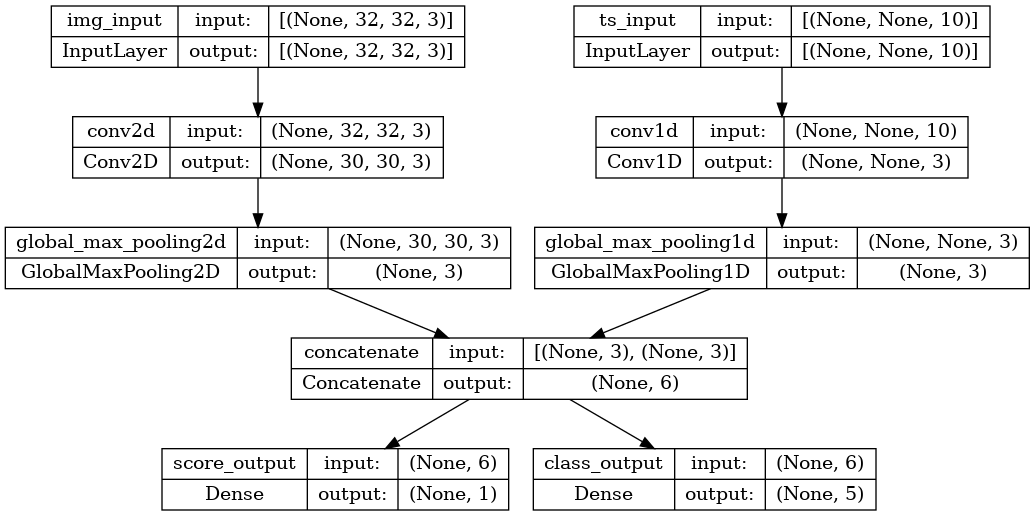

In [29]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

コンパイル時に損失関数をリストとして渡すことにより出力ごとに異なる損失を指定できます。

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

モデルに単一の損失関数のみを渡した場合、同じ損失関数がすべての出力に適用されます（ここでは適切ではありません）。

メトリクスの場合も同様です。

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

出力レイヤーに名前を付けたので、dict を介して出力ごとの損失とメトリクスを指定することもできます。

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

3 つ以上の出力がある場合は、明示的な名前とディクショナリを使用することをお勧めします。

`loss_weights` 引数を使用すると、異なる出力固有の損失に異なる重みを与えることができます（この例でクラス損失の 2 倍の重要性を与えることにより、「スコア」損失を優先する場合など）。

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

これらの出力が予測に使用するもので、トレーニングには使用されない場合、特定の出力の損失を計算しないことを選択することもできます。

In [34]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

`fit()` で多入力または多出力モデルにデータを渡すと、コンパイルで損失関数を指定するのと同じように機能します。<strong>NumPy 配列のリスト</strong>（損失関数を受け取った出力に 1:1 でマッピング）または**出力の名前を NumPy 配列にマッピングする dict** を渡すことができます。

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

1/4 [======>.......................] - ETA: 6s - loss: 17.3793 - score_output_loss: 0.1522 - class_output_loss: 17.2272

4/4 [==============================] - 2s 9ms/step - loss: 17.7520 - score_output_loss: 0.1534 - class_output_loss: 17.5986


1/4 [======>.......................] - ETA: 1s - loss: 18.4055 - score_output_loss: 0.1918 - class_output_loss: 18.2137

4/4 [==============================] - 0s 5ms/step - loss: 17.8890 - score_output_loss: 0.1902 - class_output_loss: 17.6988


以下は `Dataset` のユースケースです。NumPy 配列と同様に、`Dataset` は dicts のタプルを返します。

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

1/2 [==============>...............] - ETA: 0s - loss: 17.9856 - score_output_loss: 0.1560 - class_output_loss: 17.8296

2/2 [==============================] - 0s 19ms/step - loss: 18.1589 - score_output_loss: 0.1828 - class_output_loss: 17.9761


## コールバックを使用する

Keras のコールバックは、トレーニング中の異なる時点（エポックの始め、バッチの終わり、エポックの終わりなど）で呼び出されるオブジェクトで、以下のような動作を実装するために使用できます。

- トレーニング中に（組み込みのエポックごとの検証だけでなく）さまざまな時点で検証を行う
- 定期的に、または特定の精度しきい値を超えたときにモデルにチェックポイントを設定する
- 学習が停滞したときにモデルの学習率を変更する
- 学習が停滞したときにトップレイヤーをファインチューニングする
- トレーニング終了時、または特定のパフォーマンスしきい値を超えたときにメールまたはインスタントメッセージ通知を送信する
- など

コールバックは、リストとして `fit()` の呼び出しに渡すことができます。

In [37]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20


  1/625 [..............................] - ETA: 7:08 - loss: 2.3299 - sparse_categorical_accuracy: 0.0938

 25/625 [>.............................] - ETA: 1s - loss: 1.5719 - sparse_categorical_accuracy: 0.5825  

 50/625 [=>............................] - ETA: 1s - loss: 1.1691 - sparse_categorical_accuracy: 0.6919

 74/625 [==>...........................] - ETA: 1s - loss: 0.9805 - sparse_categorical_accuracy: 0.7397

 98/625 [===>..........................] - ETA: 1s - loss: 0.8528 - sparse_categorical_accuracy: 0.7731

122/625 [====>.........................] - ETA: 1s - loss: 0.7691 - sparse_categorical_accuracy: 0.7929

147/625 [======>.......................] - ETA: 1s - loss: 0.7026 - sparse_categorical_accuracy: 0.8095

171/625 [=======>......................] - ETA: 0s - loss: 0.6542 - sparse_categorical_accuracy: 0.8217

195/625 [========>.....................] - ETA: 0s - loss: 0.6103 - sparse_categorical_accuracy: 0.8328

219/625 [=========>....................] - ETA: 0s - loss: 0.5773 - sparse_categorical_accuracy: 0.8414

244/625 [==========>...................] - ETA: 0s - loss: 0.5528 - sparse_categorical_accuracy: 0.8474

268/625 [===========>..................] - ETA: 0s - loss: 0.5296 - sparse_categorical_accuracy: 0.8531

293/625 [=============>................] - ETA: 0s - loss: 0.5096 - sparse_categorical_accuracy: 0.8580

318/625 [==============>...............] - ETA: 0s - loss: 0.4915 - sparse_categorical_accuracy: 0.8631

343/625 [===============>..............] - ETA: 0s - loss: 0.4759 - sparse_categorical_accuracy: 0.8669

367/625 [================>.............] - ETA: 0s - loss: 0.4643 - sparse_categorical_accuracy: 0.8698

392/625 [=================>............] - ETA: 0s - loss: 0.4527 - sparse_categorical_accuracy: 0.8726

417/625 [===================>..........] - ETA: 0s - loss: 0.4405 - sparse_categorical_accuracy: 0.8755

442/625 [====================>.........] - ETA: 0s - loss: 0.4275 - sparse_categorical_accuracy: 0.8787

468/625 [=====================>........] - ETA: 0s - loss: 0.4196 - sparse_categorical_accuracy: 0.8808

494/625 [======================>.......] - ETA: 0s - loss: 0.4109 - sparse_categorical_accuracy: 0.8832

519/625 [=======================>......] - ETA: 0s - loss: 0.4022 - sparse_categorical_accuracy: 0.8857

544/625 [=========================>....] - ETA: 0s - loss: 0.3958 - sparse_categorical_accuracy: 0.8871

570/625 [==========================>...] - ETA: 0s - loss: 0.3867 - sparse_categorical_accuracy: 0.8893

596/625 [===========================>..] - ETA: 0s - loss: 0.3796 - sparse_categorical_accuracy: 0.8914

621/625 [============================>.] - ETA: 0s - loss: 0.3737 - sparse_categorical_accuracy: 0.8929

625/625 [==============================] - 3s 3ms/step - loss: 0.3721 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.2397 - val_sparse_categorical_accuracy: 0.9269


Epoch 2/20


  1/625 [..............................] - ETA: 1s - loss: 0.1503 - sparse_categorical_accuracy: 0.9531

 25/625 [>.............................] - ETA: 1s - loss: 0.1877 - sparse_categorical_accuracy: 0.9394

 50/625 [=>............................] - ETA: 1s - loss: 0.1775 - sparse_categorical_accuracy: 0.9444

 74/625 [==>...........................] - ETA: 1s - loss: 0.1740 - sparse_categorical_accuracy: 0.9451

 99/625 [===>..........................] - ETA: 1s - loss: 0.1869 - sparse_categorical_accuracy: 0.9426

123/625 [====>.........................] - ETA: 1s - loss: 0.1887 - sparse_categorical_accuracy: 0.9428

148/625 [======>.......................] - ETA: 0s - loss: 0.1880 - sparse_categorical_accuracy: 0.9419

172/625 [=======>......................] - ETA: 0s - loss: 0.1882 - sparse_categorical_accuracy: 0.9420

197/625 [========>.....................] - ETA: 0s - loss: 0.1912 - sparse_categorical_accuracy: 0.9412

222/625 [=========>....................] - ETA: 0s - loss: 0.1939 - sparse_categorical_accuracy: 0.9409

247/625 [==========>...................] - ETA: 0s - loss: 0.1927 - sparse_categorical_accuracy: 0.9414

272/625 [============>.................] - ETA: 0s - loss: 0.1890 - sparse_categorical_accuracy: 0.9422

297/625 [=============>................] - ETA: 0s - loss: 0.1930 - sparse_categorical_accuracy: 0.9412

322/625 [==============>...............] - ETA: 0s - loss: 0.1909 - sparse_categorical_accuracy: 0.9421

346/625 [===============>..............] - ETA: 0s - loss: 0.1907 - sparse_categorical_accuracy: 0.9424

371/625 [================>.............] - ETA: 0s - loss: 0.1894 - sparse_categorical_accuracy: 0.9428

395/625 [=================>............] - ETA: 0s - loss: 0.1885 - sparse_categorical_accuracy: 0.9436

420/625 [===================>..........] - ETA: 0s - loss: 0.1849 - sparse_categorical_accuracy: 0.9449

445/625 [====================>.........] - ETA: 0s - loss: 0.1851 - sparse_categorical_accuracy: 0.9450

470/625 [=====================>........] - ETA: 0s - loss: 0.1848 - sparse_categorical_accuracy: 0.9451

495/625 [======================>.......] - ETA: 0s - loss: 0.1837 - sparse_categorical_accuracy: 0.9449

520/625 [=======================>......] - ETA: 0s - loss: 0.1816 - sparse_categorical_accuracy: 0.9454

545/625 [=========================>....] - ETA: 0s - loss: 0.1815 - sparse_categorical_accuracy: 0.9456

570/625 [==========================>...] - ETA: 0s - loss: 0.1804 - sparse_categorical_accuracy: 0.9458

595/625 [===========================>..] - ETA: 0s - loss: 0.1788 - sparse_categorical_accuracy: 0.9462

620/625 [============================>.] - ETA: 0s - loss: 0.1774 - sparse_categorical_accuracy: 0.9468

625/625 [==============================] - 2s 2ms/step - loss: 0.1773 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.1920 - val_sparse_categorical_accuracy: 0.9428


Epoch 3/20


  1/625 [..............................] - ETA: 1s - loss: 0.1424 - sparse_categorical_accuracy: 0.9531

 26/625 [>.............................] - ETA: 1s - loss: 0.1456 - sparse_categorical_accuracy: 0.9597

 51/625 [=>............................] - ETA: 1s - loss: 0.1406 - sparse_categorical_accuracy: 0.9608

 75/625 [==>...........................] - ETA: 1s - loss: 0.1414 - sparse_categorical_accuracy: 0.9600

 99/625 [===>..........................] - ETA: 1s - loss: 0.1430 - sparse_categorical_accuracy: 0.9590

124/625 [====>.........................] - ETA: 1s - loss: 0.1367 - sparse_categorical_accuracy: 0.9614

149/625 [======>.......................] - ETA: 0s - loss: 0.1361 - sparse_categorical_accuracy: 0.9621

174/625 [=======>......................] - ETA: 0s - loss: 0.1359 - sparse_categorical_accuracy: 0.9626

198/625 [========>.....................] - ETA: 0s - loss: 0.1344 - sparse_categorical_accuracy: 0.9625

222/625 [=========>....................] - ETA: 0s - loss: 0.1337 - sparse_categorical_accuracy: 0.9626

247/625 [==========>...................] - ETA: 0s - loss: 0.1312 - sparse_categorical_accuracy: 0.9628

272/625 [============>.................] - ETA: 0s - loss: 0.1310 - sparse_categorical_accuracy: 0.9627

297/625 [=============>................] - ETA: 0s - loss: 0.1308 - sparse_categorical_accuracy: 0.9625

322/625 [==============>...............] - ETA: 0s - loss: 0.1310 - sparse_categorical_accuracy: 0.9626

347/625 [===============>..............] - ETA: 0s - loss: 0.1316 - sparse_categorical_accuracy: 0.9619

372/625 [================>.............] - ETA: 0s - loss: 0.1304 - sparse_categorical_accuracy: 0.9620

397/625 [==================>...........] - ETA: 0s - loss: 0.1309 - sparse_categorical_accuracy: 0.9617

422/625 [===================>..........] - ETA: 0s - loss: 0.1315 - sparse_categorical_accuracy: 0.9613

448/625 [====================>.........] - ETA: 0s - loss: 0.1310 - sparse_categorical_accuracy: 0.9611

473/625 [=====================>........] - ETA: 0s - loss: 0.1310 - sparse_categorical_accuracy: 0.9614

498/625 [======================>.......] - ETA: 0s - loss: 0.1308 - sparse_categorical_accuracy: 0.9613

523/625 [========================>.....] - ETA: 0s - loss: 0.1308 - sparse_categorical_accuracy: 0.9612

548/625 [=========================>....] - ETA: 0s - loss: 0.1306 - sparse_categorical_accuracy: 0.9615

572/625 [==========================>...] - ETA: 0s - loss: 0.1297 - sparse_categorical_accuracy: 0.9616

597/625 [===========================>..] - ETA: 0s - loss: 0.1295 - sparse_categorical_accuracy: 0.9617

621/625 [============================>.] - ETA: 0s - loss: 0.1293 - sparse_categorical_accuracy: 0.9616

625/625 [==============================] - 2s 2ms/step - loss: 0.1290 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.1583 - val_sparse_categorical_accuracy: 0.9512


Epoch 4/20


  1/625 [..............................] - ETA: 1s - loss: 0.1964 - sparse_categorical_accuracy: 0.9531

 26/625 [>.............................] - ETA: 1s - loss: 0.0872 - sparse_categorical_accuracy: 0.9760

 51/625 [=>............................] - ETA: 1s - loss: 0.0980 - sparse_categorical_accuracy: 0.9715

 76/625 [==>...........................] - ETA: 1s - loss: 0.1002 - sparse_categorical_accuracy: 0.9720

101/625 [===>..........................] - ETA: 1s - loss: 0.1011 - sparse_categorical_accuracy: 0.9700

126/625 [=====>........................] - ETA: 1s - loss: 0.0995 - sparse_categorical_accuracy: 0.9710

150/625 [======>.......................] - ETA: 0s - loss: 0.1038 - sparse_categorical_accuracy: 0.9693

175/625 [=======>......................] - ETA: 0s - loss: 0.1051 - sparse_categorical_accuracy: 0.9695

200/625 [========>.....................] - ETA: 0s - loss: 0.1049 - sparse_categorical_accuracy: 0.9697

225/625 [=========>....................] - ETA: 0s - loss: 0.1042 - sparse_categorical_accuracy: 0.9696

250/625 [===========>..................] - ETA: 0s - loss: 0.1013 - sparse_categorical_accuracy: 0.9704

275/625 [============>.................] - ETA: 0s - loss: 0.1029 - sparse_categorical_accuracy: 0.9695

301/625 [=============>................] - ETA: 0s - loss: 0.1022 - sparse_categorical_accuracy: 0.9696

326/625 [==============>...............] - ETA: 0s - loss: 0.1023 - sparse_categorical_accuracy: 0.9696

351/625 [===============>..............] - ETA: 0s - loss: 0.1032 - sparse_categorical_accuracy: 0.9694

377/625 [=================>............] - ETA: 0s - loss: 0.1036 - sparse_categorical_accuracy: 0.9694

402/625 [==================>...........] - ETA: 0s - loss: 0.1023 - sparse_categorical_accuracy: 0.9694

427/625 [===================>..........] - ETA: 0s - loss: 0.1021 - sparse_categorical_accuracy: 0.9694

452/625 [====================>.........] - ETA: 0s - loss: 0.1019 - sparse_categorical_accuracy: 0.9695

477/625 [=====================>........] - ETA: 0s - loss: 0.1030 - sparse_categorical_accuracy: 0.9694

502/625 [=======================>......] - ETA: 0s - loss: 0.1014 - sparse_categorical_accuracy: 0.9697

527/625 [========================>.....] - ETA: 0s - loss: 0.1006 - sparse_categorical_accuracy: 0.9701

552/625 [=========================>....] - ETA: 0s - loss: 0.1006 - sparse_categorical_accuracy: 0.9700

577/625 [==========================>...] - ETA: 0s - loss: 0.1015 - sparse_categorical_accuracy: 0.9699

601/625 [===========================>..] - ETA: 0s - loss: 0.1020 - sparse_categorical_accuracy: 0.9698

625/625 [==============================] - 2s 2ms/step - loss: 0.1009 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.1497 - val_sparse_categorical_accuracy: 0.9561


Epoch 5/20


  1/625 [..............................] - ETA: 2s - loss: 0.0593 - sparse_categorical_accuracy: 0.9844

 26/625 [>.............................] - ETA: 1s - loss: 0.0699 - sparse_categorical_accuracy: 0.9796

 51/625 [=>............................] - ETA: 1s - loss: 0.0880 - sparse_categorical_accuracy: 0.9730

 76/625 [==>...........................] - ETA: 1s - loss: 0.0882 - sparse_categorical_accuracy: 0.9718

101/625 [===>..........................] - ETA: 1s - loss: 0.0874 - sparse_categorical_accuracy: 0.9731

125/625 [=====>........................] - ETA: 1s - loss: 0.0860 - sparse_categorical_accuracy: 0.9731

149/625 [======>.......................] - ETA: 0s - loss: 0.0847 - sparse_categorical_accuracy: 0.9737

174/625 [=======>......................] - ETA: 0s - loss: 0.0832 - sparse_categorical_accuracy: 0.9739

199/625 [========>.....................] - ETA: 0s - loss: 0.0805 - sparse_categorical_accuracy: 0.9744

225/625 [=========>....................] - ETA: 0s - loss: 0.0812 - sparse_categorical_accuracy: 0.9738

250/625 [===========>..................] - ETA: 0s - loss: 0.0828 - sparse_categorical_accuracy: 0.9739

275/625 [============>.................] - ETA: 0s - loss: 0.0857 - sparse_categorical_accuracy: 0.9739

300/625 [=============>................] - ETA: 0s - loss: 0.0853 - sparse_categorical_accuracy: 0.9740

325/625 [==============>...............] - ETA: 0s - loss: 0.0848 - sparse_categorical_accuracy: 0.9738

349/625 [===============>..............] - ETA: 0s - loss: 0.0850 - sparse_categorical_accuracy: 0.9738

374/625 [================>.............] - ETA: 0s - loss: 0.0855 - sparse_categorical_accuracy: 0.9738

399/625 [==================>...........] - ETA: 0s - loss: 0.0852 - sparse_categorical_accuracy: 0.9739

424/625 [===================>..........] - ETA: 0s - loss: 0.0849 - sparse_categorical_accuracy: 0.9739

448/625 [====================>.........] - ETA: 0s - loss: 0.0843 - sparse_categorical_accuracy: 0.9741

472/625 [=====================>........] - ETA: 0s - loss: 0.0836 - sparse_categorical_accuracy: 0.9743

496/625 [======================>.......] - ETA: 0s - loss: 0.0834 - sparse_categorical_accuracy: 0.9744

522/625 [========================>.....] - ETA: 0s - loss: 0.0834 - sparse_categorical_accuracy: 0.9742

547/625 [=========================>....] - ETA: 0s - loss: 0.0833 - sparse_categorical_accuracy: 0.9741

572/625 [==========================>...] - ETA: 0s - loss: 0.0832 - sparse_categorical_accuracy: 0.9742

597/625 [===========================>..] - ETA: 0s - loss: 0.0836 - sparse_categorical_accuracy: 0.9741

622/625 [============================>.] - ETA: 0s - loss: 0.0832 - sparse_categorical_accuracy: 0.9743

625/625 [==============================] - 2s 2ms/step - loss: 0.0833 - sparse_categorical_accuracy: 0.9743 - val_loss: 0.1447 - val_sparse_categorical_accuracy: 0.9590


Epoch 6/20


  1/625 [..............................] - ETA: 1s - loss: 0.0655 - sparse_categorical_accuracy: 0.9688

 25/625 [>.............................] - ETA: 1s - loss: 0.0736 - sparse_categorical_accuracy: 0.9762

 51/625 [=>............................] - ETA: 1s - loss: 0.0703 - sparse_categorical_accuracy: 0.9786

 75/625 [==>...........................] - ETA: 1s - loss: 0.0769 - sparse_categorical_accuracy: 0.9771

100/625 [===>..........................] - ETA: 1s - loss: 0.0707 - sparse_categorical_accuracy: 0.9781

124/625 [====>.........................] - ETA: 1s - loss: 0.0698 - sparse_categorical_accuracy: 0.9796

148/625 [======>.......................] - ETA: 0s - loss: 0.0714 - sparse_categorical_accuracy: 0.9791

172/625 [=======>......................] - ETA: 0s - loss: 0.0684 - sparse_categorical_accuracy: 0.9797

197/625 [========>.....................] - ETA: 0s - loss: 0.0689 - sparse_categorical_accuracy: 0.9799

222/625 [=========>....................] - ETA: 0s - loss: 0.0682 - sparse_categorical_accuracy: 0.9799

247/625 [==========>...................] - ETA: 0s - loss: 0.0684 - sparse_categorical_accuracy: 0.9799

272/625 [============>.................] - ETA: 0s - loss: 0.0679 - sparse_categorical_accuracy: 0.9798

297/625 [=============>................] - ETA: 0s - loss: 0.0671 - sparse_categorical_accuracy: 0.9799

322/625 [==============>...............] - ETA: 0s - loss: 0.0670 - sparse_categorical_accuracy: 0.9801

346/625 [===============>..............] - ETA: 0s - loss: 0.0664 - sparse_categorical_accuracy: 0.9802

370/625 [================>.............] - ETA: 0s - loss: 0.0668 - sparse_categorical_accuracy: 0.9801

394/625 [=================>............] - ETA: 0s - loss: 0.0676 - sparse_categorical_accuracy: 0.9801

419/625 [===================>..........] - ETA: 0s - loss: 0.0680 - sparse_categorical_accuracy: 0.9800

443/625 [====================>.........] - ETA: 0s - loss: 0.0676 - sparse_categorical_accuracy: 0.9800

467/625 [=====================>........] - ETA: 0s - loss: 0.0686 - sparse_categorical_accuracy: 0.9797

492/625 [======================>.......] - ETA: 0s - loss: 0.0686 - sparse_categorical_accuracy: 0.9794

516/625 [=======================>......] - ETA: 0s - loss: 0.0685 - sparse_categorical_accuracy: 0.9794

541/625 [========================>.....] - ETA: 0s - loss: 0.0693 - sparse_categorical_accuracy: 0.9790

566/625 [==========================>...] - ETA: 0s - loss: 0.0688 - sparse_categorical_accuracy: 0.9791

591/625 [===========================>..] - ETA: 0s - loss: 0.0689 - sparse_categorical_accuracy: 0.9791

616/625 [============================>.] - ETA: 0s - loss: 0.0689 - sparse_categorical_accuracy: 0.9789

625/625 [==============================] - 2s 3ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.1383 - val_sparse_categorical_accuracy: 0.9609


Epoch 7/20


  1/625 [..............................] - ETA: 2s - loss: 0.0055 - sparse_categorical_accuracy: 1.0000

 25/625 [>.............................] - ETA: 1s - loss: 0.0511 - sparse_categorical_accuracy: 0.9837

 50/625 [=>............................] - ETA: 1s - loss: 0.0456 - sparse_categorical_accuracy: 0.9862

 75/625 [==>...........................] - ETA: 1s - loss: 0.0481 - sparse_categorical_accuracy: 0.9848

100/625 [===>..........................] - ETA: 1s - loss: 0.0506 - sparse_categorical_accuracy: 0.9831

125/625 [=====>........................] - ETA: 1s - loss: 0.0536 - sparse_categorical_accuracy: 0.9830

150/625 [======>.......................] - ETA: 0s - loss: 0.0558 - sparse_categorical_accuracy: 0.9824

175/625 [=======>......................] - ETA: 0s - loss: 0.0581 - sparse_categorical_accuracy: 0.9825

199/625 [========>.....................] - ETA: 0s - loss: 0.0586 - sparse_categorical_accuracy: 0.9823

224/625 [=========>....................] - ETA: 0s - loss: 0.0592 - sparse_categorical_accuracy: 0.9823

249/625 [==========>...................] - ETA: 0s - loss: 0.0588 - sparse_categorical_accuracy: 0.9822

274/625 [============>.................] - ETA: 0s - loss: 0.0588 - sparse_categorical_accuracy: 0.9824

300/625 [=============>................] - ETA: 0s - loss: 0.0584 - sparse_categorical_accuracy: 0.9822

325/625 [==============>...............] - ETA: 0s - loss: 0.0600 - sparse_categorical_accuracy: 0.9815

350/625 [===============>..............] - ETA: 0s - loss: 0.0583 - sparse_categorical_accuracy: 0.9819

375/625 [=================>............] - ETA: 0s - loss: 0.0589 - sparse_categorical_accuracy: 0.9818

400/625 [==================>...........] - ETA: 0s - loss: 0.0581 - sparse_categorical_accuracy: 0.9820

425/625 [===================>..........] - ETA: 0s - loss: 0.0580 - sparse_categorical_accuracy: 0.9821

450/625 [====================>.........] - ETA: 0s - loss: 0.0575 - sparse_categorical_accuracy: 0.9823

475/625 [=====================>........] - ETA: 0s - loss: 0.0581 - sparse_categorical_accuracy: 0.9823

500/625 [=======================>......] - ETA: 0s - loss: 0.0584 - sparse_categorical_accuracy: 0.9823

525/625 [========================>.....] - ETA: 0s - loss: 0.0582 - sparse_categorical_accuracy: 0.9824

550/625 [=========================>....] - ETA: 0s - loss: 0.0580 - sparse_categorical_accuracy: 0.9823

575/625 [==========================>...] - ETA: 0s - loss: 0.0580 - sparse_categorical_accuracy: 0.9824

600/625 [===========================>..] - ETA: 0s - loss: 0.0588 - sparse_categorical_accuracy: 0.9822

625/625 [==============================] - ETA: 0s - loss: 0.0588 - sparse_categorical_accuracy: 0.9821

625/625 [==============================] - 2s 2ms/step - loss: 0.0588 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.1437 - val_sparse_categorical_accuracy: 0.9604


Epoch 7: early stopping


### 利用できる多数の組み込みコールバック

Keras には、次のような組み込みコールバックが多数用意されています。

- `ModelCheckpoint`: モデルを定期的に保存する
- `EarlyStopping`: トレーニングによって検証指標が改善されなくなったら、トレーニングを停止する
- `TensorBoard`: [TensorBoard](https://www.tensorflow.org/tensorboard) で視覚化できるモデルログを定期的に記述する（詳細については、「視覚化」セクションを参照）。
- `CSVLogger`: 損失およびメトリクスデータを CSV ファイルにストリーミングする
- など

完全なリストについては[コールバックのドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/)をご覧ください。

### コールバックを記述する

ベースクラス `keras.callbacks.Callback` を拡張することにより、カスタムコールバックを作成できます。コールバックは、クラスプロパティ `self.model` を通じて関連するモデルにアクセスできます。

詳細については、[カスタムコールバックの作成に関する完全ガイド](https://www.tensorflow.org/guide/keras/custom_callback/)を参照してください。

以下は、トレーニング時にバッチごとの損失値のリストを保存する簡単な例です。

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## モデルにチェックポイントを設定する

比較的大きなデータセットでモデルをトレーニングする場合、モデルのチェックポイントを頻繁に保存することが重要です。

これを達成するには `ModelCheckpoint` コールバックを使用するのが最も簡単です。

In [39]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2


  1/625 [..............................] - ETA: 7:03 - loss: 2.3084 - sparse_categorical_accuracy: 0.1562

 25/625 [>.............................] - ETA: 1s - loss: 1.5073 - sparse_categorical_accuracy: 0.5831  

 49/625 [=>............................] - ETA: 1s - loss: 1.1526 - sparse_categorical_accuracy: 0.6913

 74/625 [==>...........................] - ETA: 1s - loss: 0.9605 - sparse_categorical_accuracy: 0.7422

 99/625 [===>..........................] - ETA: 1s - loss: 0.8272 - sparse_categorical_accuracy: 0.7787

124/625 [====>.........................] - ETA: 1s - loss: 0.7517 - sparse_categorical_accuracy: 0.7979

149/625 [======>.......................] - ETA: 0s - loss: 0.6895 - sparse_categorical_accuracy: 0.8133

175/625 [=======>......................] - ETA: 0s - loss: 0.6386 - sparse_categorical_accuracy: 0.8265

200/625 [========>.....................] - ETA: 0s - loss: 0.5969 - sparse_categorical_accuracy: 0.8377

224/625 [=========>....................] - ETA: 0s - loss: 0.5673 - sparse_categorical_accuracy: 0.8437

249/625 [==========>...................] - ETA: 0s - loss: 0.5407 - sparse_categorical_accuracy: 0.8505

274/625 [============>.................] - ETA: 0s - loss: 0.5186 - sparse_categorical_accuracy: 0.8562

299/625 [=============>................] - ETA: 0s - loss: 0.4990 - sparse_categorical_accuracy: 0.8617

324/625 [==============>...............] - ETA: 0s - loss: 0.4814 - sparse_categorical_accuracy: 0.8666

349/625 [===============>..............] - ETA: 0s - loss: 0.4668 - sparse_categorical_accuracy: 0.8707

374/625 [================>.............] - ETA: 0s - loss: 0.4519 - sparse_categorical_accuracy: 0.8744

399/625 [==================>...........] - ETA: 0s - loss: 0.4427 - sparse_categorical_accuracy: 0.8768

423/625 [===================>..........] - ETA: 0s - loss: 0.4296 - sparse_categorical_accuracy: 0.8803

447/625 [====================>.........] - ETA: 0s - loss: 0.4185 - sparse_categorical_accuracy: 0.8831

472/625 [=====================>........] - ETA: 0s - loss: 0.4083 - sparse_categorical_accuracy: 0.8859

497/625 [======================>.......] - ETA: 0s - loss: 0.3992 - sparse_categorical_accuracy: 0.8880

522/625 [========================>.....] - ETA: 0s - loss: 0.3897 - sparse_categorical_accuracy: 0.8906

547/625 [=========================>....] - ETA: 0s - loss: 0.3809 - sparse_categorical_accuracy: 0.8927

572/625 [==========================>...] - ETA: 0s - loss: 0.3744 - sparse_categorical_accuracy: 0.8946

597/625 [===========================>..] - ETA: 0s - loss: 0.3675 - sparse_categorical_accuracy: 0.8968

623/625 [============================>.] - ETA: 0s - loss: 0.3613 - sparse_categorical_accuracy: 0.8983


Epoch 1: val_loss improved from inf to 0.21801, saving model to mymodel_1


INFO:tensorflow:Assets written to: mymodel_1/assets


625/625 [==============================] - 3s 4ms/step - loss: 0.3613 - sparse_categorical_accuracy: 0.8983 - val_loss: 0.2180 - val_sparse_categorical_accuracy: 0.9356


Epoch 2/2


  1/625 [..............................] - ETA: 1s - loss: 0.2831 - sparse_categorical_accuracy: 0.9062

 26/625 [>.............................] - ETA: 1s - loss: 0.1828 - sparse_categorical_accuracy: 0.9453

 51/625 [=>............................] - ETA: 1s - loss: 0.1762 - sparse_categorical_accuracy: 0.9473

 76/625 [==>...........................] - ETA: 1s - loss: 0.1708 - sparse_categorical_accuracy: 0.9478

101/625 [===>..........................] - ETA: 1s - loss: 0.1794 - sparse_categorical_accuracy: 0.9448

127/625 [=====>........................] - ETA: 1s - loss: 0.1702 - sparse_categorical_accuracy: 0.9483

152/625 [======>.......................] - ETA: 0s - loss: 0.1715 - sparse_categorical_accuracy: 0.9491

177/625 [=======>......................] - ETA: 0s - loss: 0.1750 - sparse_categorical_accuracy: 0.9477

202/625 [========>.....................] - ETA: 0s - loss: 0.1766 - sparse_categorical_accuracy: 0.9476

226/625 [=========>....................] - ETA: 0s - loss: 0.1773 - sparse_categorical_accuracy: 0.9477

250/625 [===========>..................] - ETA: 0s - loss: 0.1775 - sparse_categorical_accuracy: 0.9476

275/625 [============>.................] - ETA: 0s - loss: 0.1803 - sparse_categorical_accuracy: 0.9463

300/625 [=============>................] - ETA: 0s - loss: 0.1810 - sparse_categorical_accuracy: 0.9458

325/625 [==============>...............] - ETA: 0s - loss: 0.1802 - sparse_categorical_accuracy: 0.9465

351/625 [===============>..............] - ETA: 0s - loss: 0.1796 - sparse_categorical_accuracy: 0.9469

377/625 [=================>............] - ETA: 0s - loss: 0.1773 - sparse_categorical_accuracy: 0.9474

402/625 [==================>...........] - ETA: 0s - loss: 0.1775 - sparse_categorical_accuracy: 0.9473

427/625 [===================>..........] - ETA: 0s - loss: 0.1772 - sparse_categorical_accuracy: 0.9476

452/625 [====================>.........] - ETA: 0s - loss: 0.1765 - sparse_categorical_accuracy: 0.9478

477/625 [=====================>........] - ETA: 0s - loss: 0.1755 - sparse_categorical_accuracy: 0.9481

502/625 [=======================>......] - ETA: 0s - loss: 0.1734 - sparse_categorical_accuracy: 0.9488

527/625 [========================>.....] - ETA: 0s - loss: 0.1727 - sparse_categorical_accuracy: 0.9491

552/625 [=========================>....] - ETA: 0s - loss: 0.1707 - sparse_categorical_accuracy: 0.9497

577/625 [==========================>...] - ETA: 0s - loss: 0.1703 - sparse_categorical_accuracy: 0.9499

602/625 [===========================>..] - ETA: 0s - loss: 0.1685 - sparse_categorical_accuracy: 0.9505


Epoch 2: val_loss improved from 0.21801 to 0.17181, saving model to mymodel_2


INFO:tensorflow:Assets written to: mymodel_2/assets


625/625 [==============================] - 2s 3ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.9507 - val_loss: 0.1718 - val_sparse_categorical_accuracy: 0.9494


`ModelCheckpoint` コールバックを使用するとフォールトトレランスを実装できます。フォールトトレランスはトレーニングがランダムに中断された場合に、モデルの最後に保存された状態からトレーニングを再開する機能です。 以下は基本的な例です。

In [40]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model


   1/1563 [..............................] - ETA: 17:50 - loss: 2.3009 - sparse_categorical_accuracy: 0.0938

  23/1563 [..............................] - ETA: 3s - loss: 1.7067 - sparse_categorical_accuracy: 0.5177   

  46/1563 [..............................] - ETA: 3s - loss: 1.3338 - sparse_categorical_accuracy: 0.6399

  70/1563 [>.............................] - ETA: 3s - loss: 1.1157 - sparse_categorical_accuracy: 0.6982

  93/1563 [>.............................] - ETA: 3s - loss: 1.0051 - sparse_categorical_accuracy: 0.7275

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.97/assets


 100/1563 [>.............................] - ETA: 9s - loss: 0.9686 - sparse_categorical_accuracy: 0.7362

 122/1563 [=>............................] - ETA: 8s - loss: 0.8833 - sparse_categorical_accuracy: 0.7574

 145/1563 [=>............................] - ETA: 7s - loss: 0.8079 - sparse_categorical_accuracy: 0.7769

 168/1563 [==>...........................] - ETA: 6s - loss: 0.7571 - sparse_categorical_accuracy: 0.7892

 191/1563 [==>...........................] - ETA: 6s - loss: 0.7122 - sparse_categorical_accuracy: 0.8002

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.70/assets


 200/1563 [==>...........................] - ETA: 8s - loss: 0.6957 - sparse_categorical_accuracy: 0.8044

 223/1563 [===>..........................] - ETA: 8s - loss: 0.6609 - sparse_categorical_accuracy: 0.8143

 246/1563 [===>..........................] - ETA: 7s - loss: 0.6319 - sparse_categorical_accuracy: 0.8228

 269/1563 [====>.........................] - ETA: 7s - loss: 0.6092 - sparse_categorical_accuracy: 0.8280

 292/1563 [====>.........................] - ETA: 6s - loss: 0.5911 - sparse_categorical_accuracy: 0.8332

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.58/assets


 300/1563 [====>.........................] - ETA: 8s - loss: 0.5846 - sparse_categorical_accuracy: 0.8352

 323/1563 [=====>........................] - ETA: 7s - loss: 0.5682 - sparse_categorical_accuracy: 0.8395

 346/1563 [=====>........................] - ETA: 7s - loss: 0.5498 - sparse_categorical_accuracy: 0.8442

 369/1563 [======>.......................] - ETA: 6s - loss: 0.5364 - sparse_categorical_accuracy: 0.8477

 392/1563 [======>.......................] - ETA: 6s - loss: 0.5261 - sparse_categorical_accuracy: 0.8508

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.52/assets


 400/1563 [======>.......................] - ETA: 7s - loss: 0.5231 - sparse_categorical_accuracy: 0.8512

 423/1563 [=======>......................] - ETA: 7s - loss: 0.5124 - sparse_categorical_accuracy: 0.8549

 447/1563 [=======>......................] - ETA: 6s - loss: 0.5010 - sparse_categorical_accuracy: 0.8582

 470/1563 [========>.....................] - ETA: 6s - loss: 0.4920 - sparse_categorical_accuracy: 0.8606

 493/1563 [========>.....................] - ETA: 6s - loss: 0.4797 - sparse_categorical_accuracy: 0.8638

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.48/assets


 500/1563 [========>.....................] - ETA: 6s - loss: 0.4763 - sparse_categorical_accuracy: 0.8646

 522/1563 [=========>....................] - ETA: 6s - loss: 0.4667 - sparse_categorical_accuracy: 0.8673

 546/1563 [=========>....................] - ETA: 6s - loss: 0.4593 - sparse_categorical_accuracy: 0.8689

 568/1563 [=========>....................] - ETA: 6s - loss: 0.4523 - sparse_categorical_accuracy: 0.8706

 591/1563 [==========>...................] - ETA: 5s - loss: 0.4459 - sparse_categorical_accuracy: 0.8723

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.44/assets


 600/1563 [==========>...................] - ETA: 6s - loss: 0.4441 - sparse_categorical_accuracy: 0.8729

 623/1563 [==========>...................] - ETA: 6s - loss: 0.4387 - sparse_categorical_accuracy: 0.8743

 646/1563 [===========>..................] - ETA: 5s - loss: 0.4310 - sparse_categorical_accuracy: 0.8768

 669/1563 [===========>..................] - ETA: 5s - loss: 0.4244 - sparse_categorical_accuracy: 0.8788

 692/1563 [============>.................] - ETA: 5s - loss: 0.4205 - sparse_categorical_accuracy: 0.8794

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.42/assets


 700/1563 [============>.................] - ETA: 5s - loss: 0.4184 - sparse_categorical_accuracy: 0.8800

 722/1563 [============>.................] - ETA: 5s - loss: 0.4135 - sparse_categorical_accuracy: 0.8814

 745/1563 [=============>................] - ETA: 5s - loss: 0.4079 - sparse_categorical_accuracy: 0.8831

 768/1563 [=============>................] - ETA: 4s - loss: 0.4029 - sparse_categorical_accuracy: 0.8847

 791/1563 [==============>...............] - ETA: 4s - loss: 0.3981 - sparse_categorical_accuracy: 0.8861

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.40/assets


 800/1563 [==============>...............] - ETA: 5s - loss: 0.3960 - sparse_categorical_accuracy: 0.8866

 823/1563 [==============>...............] - ETA: 4s - loss: 0.3918 - sparse_categorical_accuracy: 0.8878

 846/1563 [===============>..............] - ETA: 4s - loss: 0.3871 - sparse_categorical_accuracy: 0.8892

 869/1563 [===============>..............] - ETA: 4s - loss: 0.3823 - sparse_categorical_accuracy: 0.8904

 893/1563 [================>.............] - ETA: 4s - loss: 0.3781 - sparse_categorical_accuracy: 0.8916

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.38/assets


 900/1563 [================>.............] - ETA: 4s - loss: 0.3770 - sparse_categorical_accuracy: 0.8919

 922/1563 [================>.............] - ETA: 4s - loss: 0.3740 - sparse_categorical_accuracy: 0.8928

 945/1563 [=================>............] - ETA: 4s - loss: 0.3711 - sparse_categorical_accuracy: 0.8935

 968/1563 [=================>............] - ETA: 3s - loss: 0.3669 - sparse_categorical_accuracy: 0.8945

 991/1563 [==================>...........] - ETA: 3s - loss: 0.3646 - sparse_categorical_accuracy: 0.8953

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.36/assets


1000/1563 [==================>...........] - ETA: 3s - loss: 0.3628 - sparse_categorical_accuracy: 0.8957

1023/1563 [==================>...........] - ETA: 3s - loss: 0.3592 - sparse_categorical_accuracy: 0.8969

1045/1563 [===================>..........] - ETA: 3s - loss: 0.3565 - sparse_categorical_accuracy: 0.8978

1067/1563 [===================>..........] - ETA: 3s - loss: 0.3537 - sparse_categorical_accuracy: 0.8987

1090/1563 [===================>..........] - ETA: 3s - loss: 0.3503 - sparse_categorical_accuracy: 0.8997

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.35/assets


1100/1563 [====================>.........] - ETA: 3s - loss: 0.3488 - sparse_categorical_accuracy: 0.9000

1122/1563 [====================>.........] - ETA: 2s - loss: 0.3463 - sparse_categorical_accuracy: 0.9007

1145/1563 [====================>.........] - ETA: 2s - loss: 0.3429 - sparse_categorical_accuracy: 0.9014

1168/1563 [=====================>........] - ETA: 2s - loss: 0.3399 - sparse_categorical_accuracy: 0.9023

1191/1563 [=====================>........] - ETA: 2s - loss: 0.3379 - sparse_categorical_accuracy: 0.9027

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.34/assets


1200/1563 [======================>.......] - ETA: 2s - loss: 0.3366 - sparse_categorical_accuracy: 0.9030

1223/1563 [======================>.......] - ETA: 2s - loss: 0.3339 - sparse_categorical_accuracy: 0.9037

1246/1563 [======================>.......] - ETA: 2s - loss: 0.3307 - sparse_categorical_accuracy: 0.9045

1269/1563 [=======================>......] - ETA: 1s - loss: 0.3282 - sparse_categorical_accuracy: 0.9051

1292/1563 [=======================>......] - ETA: 1s - loss: 0.3256 - sparse_categorical_accuracy: 0.9059

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.32/assets


1300/1563 [=======================>......] - ETA: 1s - loss: 0.3247 - sparse_categorical_accuracy: 0.9061

1323/1563 [========================>.....] - ETA: 1s - loss: 0.3227 - sparse_categorical_accuracy: 0.9067

1346/1563 [========================>.....] - ETA: 1s - loss: 0.3210 - sparse_categorical_accuracy: 0.9071

1369/1563 [=========================>....] - ETA: 1s - loss: 0.3181 - sparse_categorical_accuracy: 0.9079

1392/1563 [=========================>....] - ETA: 1s - loss: 0.3156 - sparse_categorical_accuracy: 0.9088

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.31/assets


1400/1563 [=========================>....] - ETA: 1s - loss: 0.3148 - sparse_categorical_accuracy: 0.9090

1422/1563 [==========================>...] - ETA: 0s - loss: 0.3122 - sparse_categorical_accuracy: 0.9096

1445/1563 [==========================>...] - ETA: 0s - loss: 0.3099 - sparse_categorical_accuracy: 0.9103

1468/1563 [===========================>..] - ETA: 0s - loss: 0.3081 - sparse_categorical_accuracy: 0.9109

1491/1563 [===========================>..] - ETA: 0s - loss: 0.3063 - sparse_categorical_accuracy: 0.9114

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.31/assets


1500/1563 [===========================>..] - ETA: 0s - loss: 0.3056 - sparse_categorical_accuracy: 0.9116

1523/1563 [============================>.] - ETA: 0s - loss: 0.3040 - sparse_categorical_accuracy: 0.9121

1546/1563 [============================>.] - ETA: 0s - loss: 0.3018 - sparse_categorical_accuracy: 0.9128

1563/1563 [==============================] - 11s 6ms/step - loss: 0.3004 - sparse_categorical_accuracy: 0.9132


また、モデルを保存および復元するための独自のコールバックを記述することもできます。

シリアル化と保存の完全なガイドについては、[モデルの保存とシリアル化に関するガイド](https://www.tensorflow.org/guide/keras/save_and_serialize/)をご覧ください。

## 学習率スケジュールを使用する

ディープラーニングモデルをトレーニングする際は、一般的に、トレーニングが進むにつれて徐々に学習進度が減少するパターンが見られます。これは一般に「学習率の減衰」として知られています。

学習減衰スケジュールは、静的（その時点のエポックまたはその時点のバッチインデックスの関数として事前に指定）または動的（モデルの現在の動作、特に検証損失に対応）にすることができます。

### オプティマイザにスケジュールを渡す

オプティマイザの `learning_rate` 引数としてスケジュールオブジェクトを渡すことで、静的学習率の減衰スケジュールを簡単に使用できます。

In [41]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

組み込みスケジュールには、`ExponentialDecay`、`PiecewiseConstantDecay`、`PolynomialDecay`、および `InverseTimeDecay` を利用できます。

### コールバックを使用して動的学習率スケジュールを実装する

オプティマイザは検証メトリクスにアクセスできないため、これらのスケジュールオブジェクトでは動的学習率のスケジュール（検証の損失が改善されなくなったときに学習率を下げるなど）を実現できません。

ただし、コールバックは、検証メトリクスを含むすべてのメトリクスにアクセスできます。このパターンでは、コールバックを使用してオプティマイザのその時点の学習率を変更します。これは`ReduceLROnPlateau` コールバックとして組み込まれています。

## トレーニング時の損失とメトリクスを視覚化する

トレーニング時にモデルを監視する場合、[TensorBoard](https://www.tensorflow.org/tensorboard) を使用するのが最善の方法です。これは、ローカルで実行できるブラウザベースのアプリケーションで、以下の機能を提供します。

- トレーニングと評価のための損失とメトリクスのライブプロット
- レイヤーアクティベーションのヒストグラムの視覚化（オプション）
- `Embedding` レイヤーが学習した埋め込みスペースの 3D 視覚化（オプション）

TensorFlow を pip でインストールした場合は、コマンドラインから TensorBoard を起動できます。

```
tensorboard --logdir=/full_path_to_your_logs
```

### TensorBoard コールバックを使用する

Keras モデルと `fit()` メソッドで TensorBoard を使用するには、`TensorBoard` コールバックを使用するのが最も簡単です。

最も単純なケースでは、コールバックがログを書き込む場所を指定するだけで完了します。

In [42]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

詳細については、[`TensorBoard`コールバックのドキュメント](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/tensorboard/)を参照してください。